In [1]:
%matplotlib inline

# useful packages
import matplotlib.pyplot as plt
import matplotlib.axes as axes
import numpy as np
import networkx as nx

from qiskit.tools.visualization import plot_histogram
from qiskit.circuit.library import TwoLocal
from qiskit_optimization.applications import Maxcut, Tsp
from qiskit.algorithms import VQE, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import SPSA
from qiskit.utils import algorithm_globals, QuantumInstance
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_optimization.problems import QuadraticProgram
from qiskit import Aer, IBMQ
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram
from qiskit.visualization import plot_state_city, plot_bloch_multivector
from qiskit.visualization import plot_state_paulivec, plot_state_hinton
from qiskit.visualization import plot_state_qsphere

## MaxCut 2x2 Ising Model

In [2]:
# Generating the system

N = 2
G1 = nx.grid_2d_graph(N,N)
pos = dict( (n, n) for n in G1.nodes() )
labels = dict( ((i, j), i * N + j) for i, j in G1.nodes() )

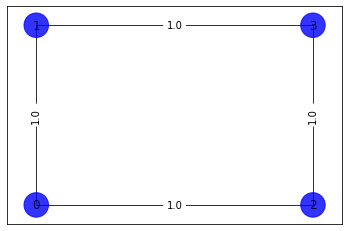

In [3]:
# Transform to weighted graph:
n = N**2
V = np.arange(0, N, 1)

E =[]

tuples = []
other_tup = []
point_edge_map = []
other_map = []
relations = []

for edge in G1.edges:
    point1 = edge[0]
    strpoint1 = str(point1[0]) + str(point1[1])
    point2 = edge[1]
    strpoint2 = str(point2[0]) + str(point2[1])
    if not strpoint1 in point_edge_map:
        point_edge_map.append(strpoint1)
        tuples.append(edge[0])
    if not strpoint2 in other_map:
        other_map.append(strpoint2)
        other_tup.append(edge[1])
    relations.append((strpoint1, strpoint2))

tuples.append(other_tup[len(other_tup) - 1])
point_edge_map.append(other_map[len(other_map) - 1])

dic = {}
for i in range(len(point_edge_map)):
    dic[i] = point_edge_map[i]
    
point_edge_map = np.array(point_edge_map)
relations = np.array(relations)

for relation in relations:
    ver1 = relation[0]
    ver2 = relation[1]
    point1 = np.where(point_edge_map == ver1)[0][0]
    point2 = np.where(point_edge_map == ver2)[0][0]
    edge = (point1, point2, 1.0)
    E.append(edge)
    
G = nx.Graph()

G.add_nodes_from(V)

G.add_weighted_edges_from(E)

colors = ["b" for node in G.nodes()]
pos = dict()
for i in range(n):
    pos[i] = tuples[i]

def draw_graph(G, colors, pos):
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=0.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)


draw_graph(G, colors, pos)

In [4]:
# Matrix Representation of Graph
w = np.zeros([n, n])
for i in range(n):
    for j in range(n):
        temp = G.get_edge_data(i, j, default=0)
        if temp != 0:
            w[i, j] = temp["weight"]

print(w)

[[0. 1. 1. 0.]
 [1. 0. 0. 1.]
 [1. 0. 0. 1.]
 [0. 1. 1. 0.]]


### Mapping to the Ising problem

Qiskit provides functionality to generate `QuadraticProgram` from the problem specification as well as create the corresponding Ising Hamiltonian.

In [5]:
max_cut = Maxcut(w)
qp = max_cut.to_quadratic_program()
print(qp.prettyprint())

Problem name: Max-cut

Maximize
  -2*x_0*x_1 - 2*x_0*x_2 - 2*x_1*x_3 - 2*x_2*x_3 + 2*x_0 + 2*x_1 + 2*x_2 + 2*x_3

Subject to
  No constraints

  Binary variables (4)
    x_0 x_1 x_2 x_3



In [6]:
qubitOp, offset = qp.to_ising()
print("Offset:", offset)
print("Ising Hamiltonian:")
print(str(qubitOp))

Offset: -2.0
Ising Hamiltonian:
0.5 * IIZZ
+ 0.5 * IZIZ
+ 0.5 * ZIZI
+ 0.5 * ZZII


In [7]:
# solving Quadratic Program using exact classical eigensolver
exact = MinimumEigenOptimizer(NumPyMinimumEigensolver())
result = exact.solve(qp)
print(result.prettyprint())

objective function value: 4.0
variable values: x_0=0.0, x_1=1.0, x_2=1.0, x_3=0.0
status: SUCCESS


### Running it on quantum computer
We run the optimization routine using a feedback loop with a quantum computer that uses trial functions built with Y single-qubit rotations, $U_\mathrm{single}(\theta) = \prod_{i=1}^n Y(\theta_{i})$, and entangler steps $U_\mathrm{entangler}$.

In [8]:
algorithm_globals.random_seed = 123
seed = 10598
backend = Aer.get_backend('statevector_simulator')
quantum_instance = QuantumInstance(backend, seed_simulator=seed, seed_transpiler=seed)

results:  [ 2.48389960e-04+0.j -2.97743195e-03+0.j -8.89933681e-03+0.j
  7.76887661e-06+0.j -4.07881685e-03+0.j -1.73431231e-02+0.j
 -9.99093800e-01+0.j -9.76524541e-04+0.j -7.17145927e-03+0.j
  3.65934970e-02+0.j  3.78917727e-03+0.j -2.70178284e-04+0.j
  6.36879315e-05+0.j -3.11468327e-04+0.j  1.83920898e-04+0.j
  1.24539637e-05+0.j]
energy: -1.9990548861735566
time: 1.2122912406921387
max-cut objective: -3.999054886173557
solution: [0. 1. 1. 0.]
solution objective: 4.0
sum of eigenstates squared:  (1.0000000000000004+0j)


/Users/youfuqian/opt/anaconda3/envs/qiskit_latest/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


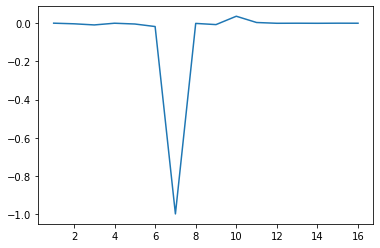

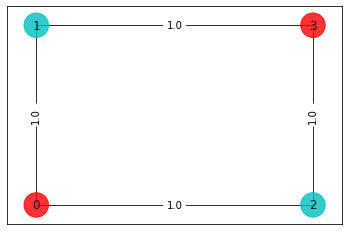

In [9]:
# construct VQE
spsa = SPSA(maxiter=300)
ry = TwoLocal(qubitOp.num_qubits, "ry", "cz", reps=5, entanglement="linear")
vqe = VQE(ry, optimizer=spsa, quantum_instance=quantum_instance)

# run VQE
result = vqe.compute_minimum_eigenvalue(qubitOp)

# print results
x = max_cut.sample_most_likely(result.eigenstate)
print("results: ", result.eigenstate)
print("energy:", result.eigenvalue.real)
print("time:", result.optimizer_time)
print("max-cut objective:", result.eigenvalue.real + offset)
print("solution:", x)
print("solution objective:", qp.objective.evaluate(x))
print("sum of eigenstates squared: ", sum(np.conj(result.eigenstate) * result.eigenstate))
horizontal = np.linspace(1, len(result.eigenstate), num = len(result.eigenstate))
plt.figure()
plt.plot(horizontal, result.eigenstate)


# plot results
plt.figure()
colors = ["r" if x[i] == 0 else "c" for i in range(n)]
draw_graph(G, colors, pos)

## MaxCut 3x3 Ising Model

In [10]:
# Generating the system

N = 3
G1 = nx.grid_2d_graph(N,N)
pos = dict( (n, n) for n in G1.nodes() )
labels = dict( ((i, j), i * N + j) for i, j in G1.nodes() )

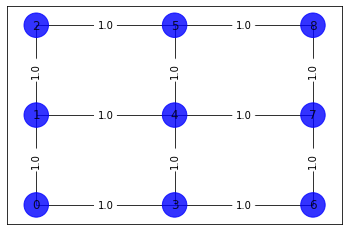

In [11]:
# Transform to weighted graph:
n = N**2
V = np.arange(0, N, 1)

E =[]

tuples = []
other_tup = []
point_edge_map = []
other_map = []
relations = []

for edge in G1.edges:
    point1 = edge[0]
    strpoint1 = str(point1[0]) + str(point1[1])
    point2 = edge[1]
    strpoint2 = str(point2[0]) + str(point2[1])
    if not strpoint1 in point_edge_map:
        point_edge_map.append(strpoint1)
        tuples.append(edge[0])
    if not strpoint2 in other_map:
        other_map.append(strpoint2)
        other_tup.append(edge[1])
    relations.append((strpoint1, strpoint2))

tuples.append(other_tup[len(other_tup) - 1])
point_edge_map.append(other_map[len(other_map) - 1])

dic = {}
for i in range(len(point_edge_map)):
    dic[i] = point_edge_map[i]
    
point_edge_map = np.array(point_edge_map)
relations = np.array(relations)

for relation in relations:
    ver1 = relation[0]
    ver2 = relation[1]
    point1 = np.where(point_edge_map == ver1)[0][0]
    point2 = np.where(point_edge_map == ver2)[0][0]
    edge = (point1, point2, 1.0)
    E.append(edge)
    
G = nx.Graph()

G.add_nodes_from(V)

G.add_weighted_edges_from(E)

colors = ["b" for node in G.nodes()]
pos = dict()
for i in range(n):
    pos[i] = tuples[i]

def draw_graph(G, colors, pos):
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=0.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)


draw_graph(G, colors, pos)

In [12]:
# Matrix Representation of Graph
w = np.zeros([n, n])
for i in range(n):
    for j in range(n):
        temp = G.get_edge_data(i, j, default=0)
        if temp != 0:
            w[i, j] = temp["weight"]

print(w)

[[0. 1. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 1. 0. 1. 0. 0.]
 [0. 1. 0. 1. 0. 1. 0. 1. 0.]
 [0. 0. 1. 0. 1. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0. 1. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0. 1. 0.]]


## Classical (Brute Force) Approach

In [13]:
%%time

best_cost_brute = 0
config = []
costs = []
for b in range(2**n):
    x = [int(t) for t in reversed(list(bin(b)[2:].zfill(n)))]
    cost = 0
    for i in range(n):
        for j in range(n):
            cost = cost + w[i, j] * x[i] * (1 - x[j])
    if best_cost_brute < cost:
        best_cost_brute = cost
        xbest_brute = x
    config.append((x, ))
    costs.append(cost)
    # print("case = " + str(x) + " cost = " + str(cost))

# choose the more stable configuration
E = []
low_ind = np.argwhere(costs == np.amax(costs)).flatten()
for i in range(len(low_ind)):
    E.append(sum(config[low_ind[i]][0]))
min_loc = np.argmin(E)
xbest_brute = config[low_ind[min_loc]][0]

print("\nBest solution = " + str(xbest_brute) + " cost = " + str(best_cost_brute))


Best solution = [0, 1, 0, 1, 0, 1, 0, 1, 0] cost = 12.0
CPU times: user 27 ms, sys: 45.8 ms, total: 72.8 ms
Wall time: 20.4 ms


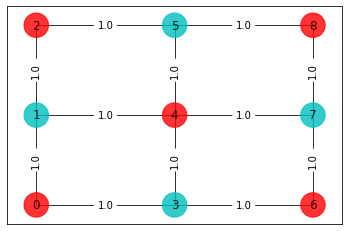

In [14]:
# red = spin down, blue = spin up
colors = ["r" if xbest_brute[i] == 0 else "c" for i in range(n)]
draw_graph(G, colors, pos)

### Mapping to the Ising problem

Qiskit provides functionality to generate `QuadraticProgram` from the problem specification as well as create the corresponding Ising Hamiltonian.

In [15]:
max_cut = Maxcut(w)
qp = max_cut.to_quadratic_program()
print(qp.prettyprint())

Problem name: Max-cut

Maximize
  -2*x_0*x_1 - 2*x_0*x_3 - 2*x_1*x_2 - 2*x_1*x_4 - 2*x_2*x_5 - 2*x_3*x_4
  - 2*x_3*x_6 - 2*x_4*x_5 - 2*x_4*x_7 - 2*x_5*x_8 - 2*x_6*x_7 - 2*x_7*x_8
  + 2*x_0 + 3*x_1 + 2*x_2 + 3*x_3 + 4*x_4 + 3*x_5 + 2*x_6 + 3*x_7 + 2*x_8

Subject to
  No constraints

  Binary variables (9)
    x_0 x_1 x_2 x_3 x_4 x_5 x_6 x_7 x_8



In [16]:
qubitOp, offset = qp.to_ising()
print("Offset:", offset)
print("Ising Hamiltonian:")
print(str(qubitOp))

Offset: -6.0
Ising Hamiltonian:
0.5 * IIIIIIIZZ
+ 0.5 * IIIIIIZZI
+ 0.5 * IIIIIZIIZ
+ 0.5 * IIIIZIIZI
+ 0.5 * IIIIZZIII
+ 0.5 * IIIZIIZII
+ 0.5 * IIIZZIIII
+ 0.5 * IIZIIZIII
+ 0.5 * IZIIZIIII
+ 0.5 * IZZIIIIII
+ 0.5 * ZIIZIIIII
+ 0.5 * ZZIIIIIII


In [17]:
# solving Quadratic Program using exact classical eigensolver
exact = MinimumEigenOptimizer(NumPyMinimumEigensolver())
result = exact.solve(qp)
print(result.prettyprint())

objective function value: 12.0
variable values: x_0=0.0, x_1=1.0, x_2=0.0, x_3=1.0, x_4=0.0, x_5=1.0, x_6=0.0, x_7=1.0, x_8=0.0
status: SUCCESS


### Checking that the full Hamiltonian gives the right cost 

energy: -6.0
max-cut objective: -12.0
solution: [0 1 0 1 0 1 0 1 0]
solution objective: 12.0


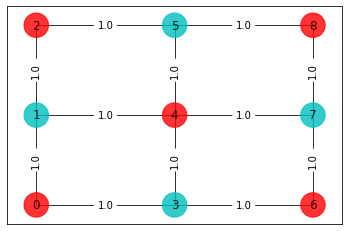

In [18]:
# Making the Hamiltonian in its full form and getting the lowest eigenvalue and eigenvector
ee = NumPyMinimumEigensolver()
result = ee.compute_minimum_eigenvalue(qubitOp)

x = max_cut.sample_most_likely(result.eigenstate)
print("energy:", result.eigenvalue.real)
print("max-cut objective:", result.eigenvalue.real + offset)
print("solution:", x)
print("solution objective:", qp.objective.evaluate(x))

colors = ["r" if x[i] == 0 else "c" for i in range(n)]
draw_graph(G, colors, pos)

### Running it on quantum computer
We run the optimization routine using a feedback loop with a quantum computer that uses trial functions built with Y single-qubit rotations, $U_\mathrm{single}(\theta) = \prod_{i=1}^n Y(\theta_{i})$, and entangler steps $U_\mathrm{entangler}$.

In [19]:
# Check backends
Aer.backends()

[AerSimulator('aer_simulator'),
 AerSimulator('aer_simulator_statevector'),
 AerSimulator('aer_simulator_density_matrix'),
 AerSimulator('aer_simulator_stabilizer'),
 AerSimulator('aer_simulator_matrix_product_state'),
 AerSimulator('aer_simulator_extended_stabilizer'),
 AerSimulator('aer_simulator_unitary'),
 AerSimulator('aer_simulator_superop'),
 QasmSimulator('qasm_simulator'),
 StatevectorSimulator('statevector_simulator'),
 UnitarySimulator('unitary_simulator'),
 PulseSimulator('pulse_simulator')]

In [20]:
algorithm_globals.random_seed = 123
seed = 10598
backend = Aer.get_backend('statevector_simulator')
quantum_instance = QuantumInstance(backend, seed_simulator=seed, seed_transpiler=seed)

In [21]:
# construct VQE
spsa = SPSA(maxiter=300)
ry = TwoLocal(qubitOp.num_qubits, "ry", "cz", reps=5, entanglement="linear")
vqe = VQE(ry, optimizer=spsa, quantum_instance = quantum_instance)

# run VQE
result = vqe.compute_minimum_eigenvalue(qubitOp)

# print results
x = max_cut.sample_most_likely(result.eigenstate)
print("result: ", result)
print("energy:", result.eigenvalue.real)
print("time:", result.optimizer_time)
print("max-cut objective:", result.eigenvalue.real + offset)
print("solution:", x)
print("solution objective:", qp.objective.evaluate(x))
print("sum of eigenstates squared: ", sum(np.conj(result.eigenstate) * result.eigenstate))

result:  {   'aux_operator_eigenvalues': None,
    'cost_function_evals': 600,
    'eigenstate': array([-1.66830802e-06+0.j, -1.09408641e-05+0.j,  2.05983205e-06+0.j,
        1.33800511e-05+0.j, -3.65475725e-06+0.j, -7.37792464e-05+0.j,
        5.73639289e-06+0.j, -3.08135615e-06+0.j,  2.31628323e-06+0.j,
       -2.87944712e-05+0.j,  7.95981933e-06+0.j, -5.24122872e-05+0.j,
        1.79781446e-06+0.j,  9.49733922e-05+0.j, -7.76072197e-06+0.j,
        1.69607866e-05+0.j, -3.49754959e-05+0.j, -1.95698904e-04+0.j,
        7.31464220e-05+0.j,  2.22825960e-04+0.j, -9.03843596e-05+0.j,
       -1.65572346e-03+0.j,  1.41072081e-04+0.j, -1.20130377e-04+0.j,
        3.90576574e-06+0.j,  6.12866574e-05+0.j,  1.46722892e-05+0.j,
       -1.90689773e-05+0.j, -6.88178459e-06+0.j, -7.44613099e-05+0.j,
        1.90258905e-06+0.j, -1.13965562e-05+0.j, -3.67012681e-05+0.j,
       -2.14089157e-04+0.j,  7.14999222e-05+0.j,  2.33711085e-04+0.j,
       -9.20163941e-05+0.j, -1.69202742e-03+0.j,  1.44268239e-0

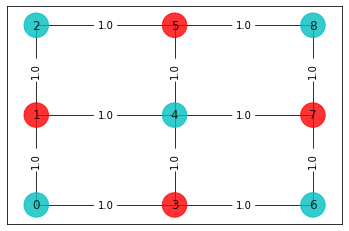

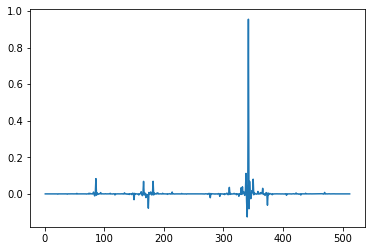

In [22]:
# plot results
colors = ["r" if x[i] == 0 else "c" for i in range(n)]
draw_graph(G, colors, pos)
horizontal = np.linspace(1, len(result.eigenstate), num = len(result.eigenstate))
plt.figure()
plt.plot(horizontal, result.eigenstate)

Trial 0:
energy: -5.966642699978674
time: 3.2583909034729004
max-cut objective: -11.966642699978674
solution: [1. 0. 1. 0. 1. 0. 1. 0. 1.]
solution objective: 12.0
sum of eigenstates squared:  (0.9999999999999996+0j)


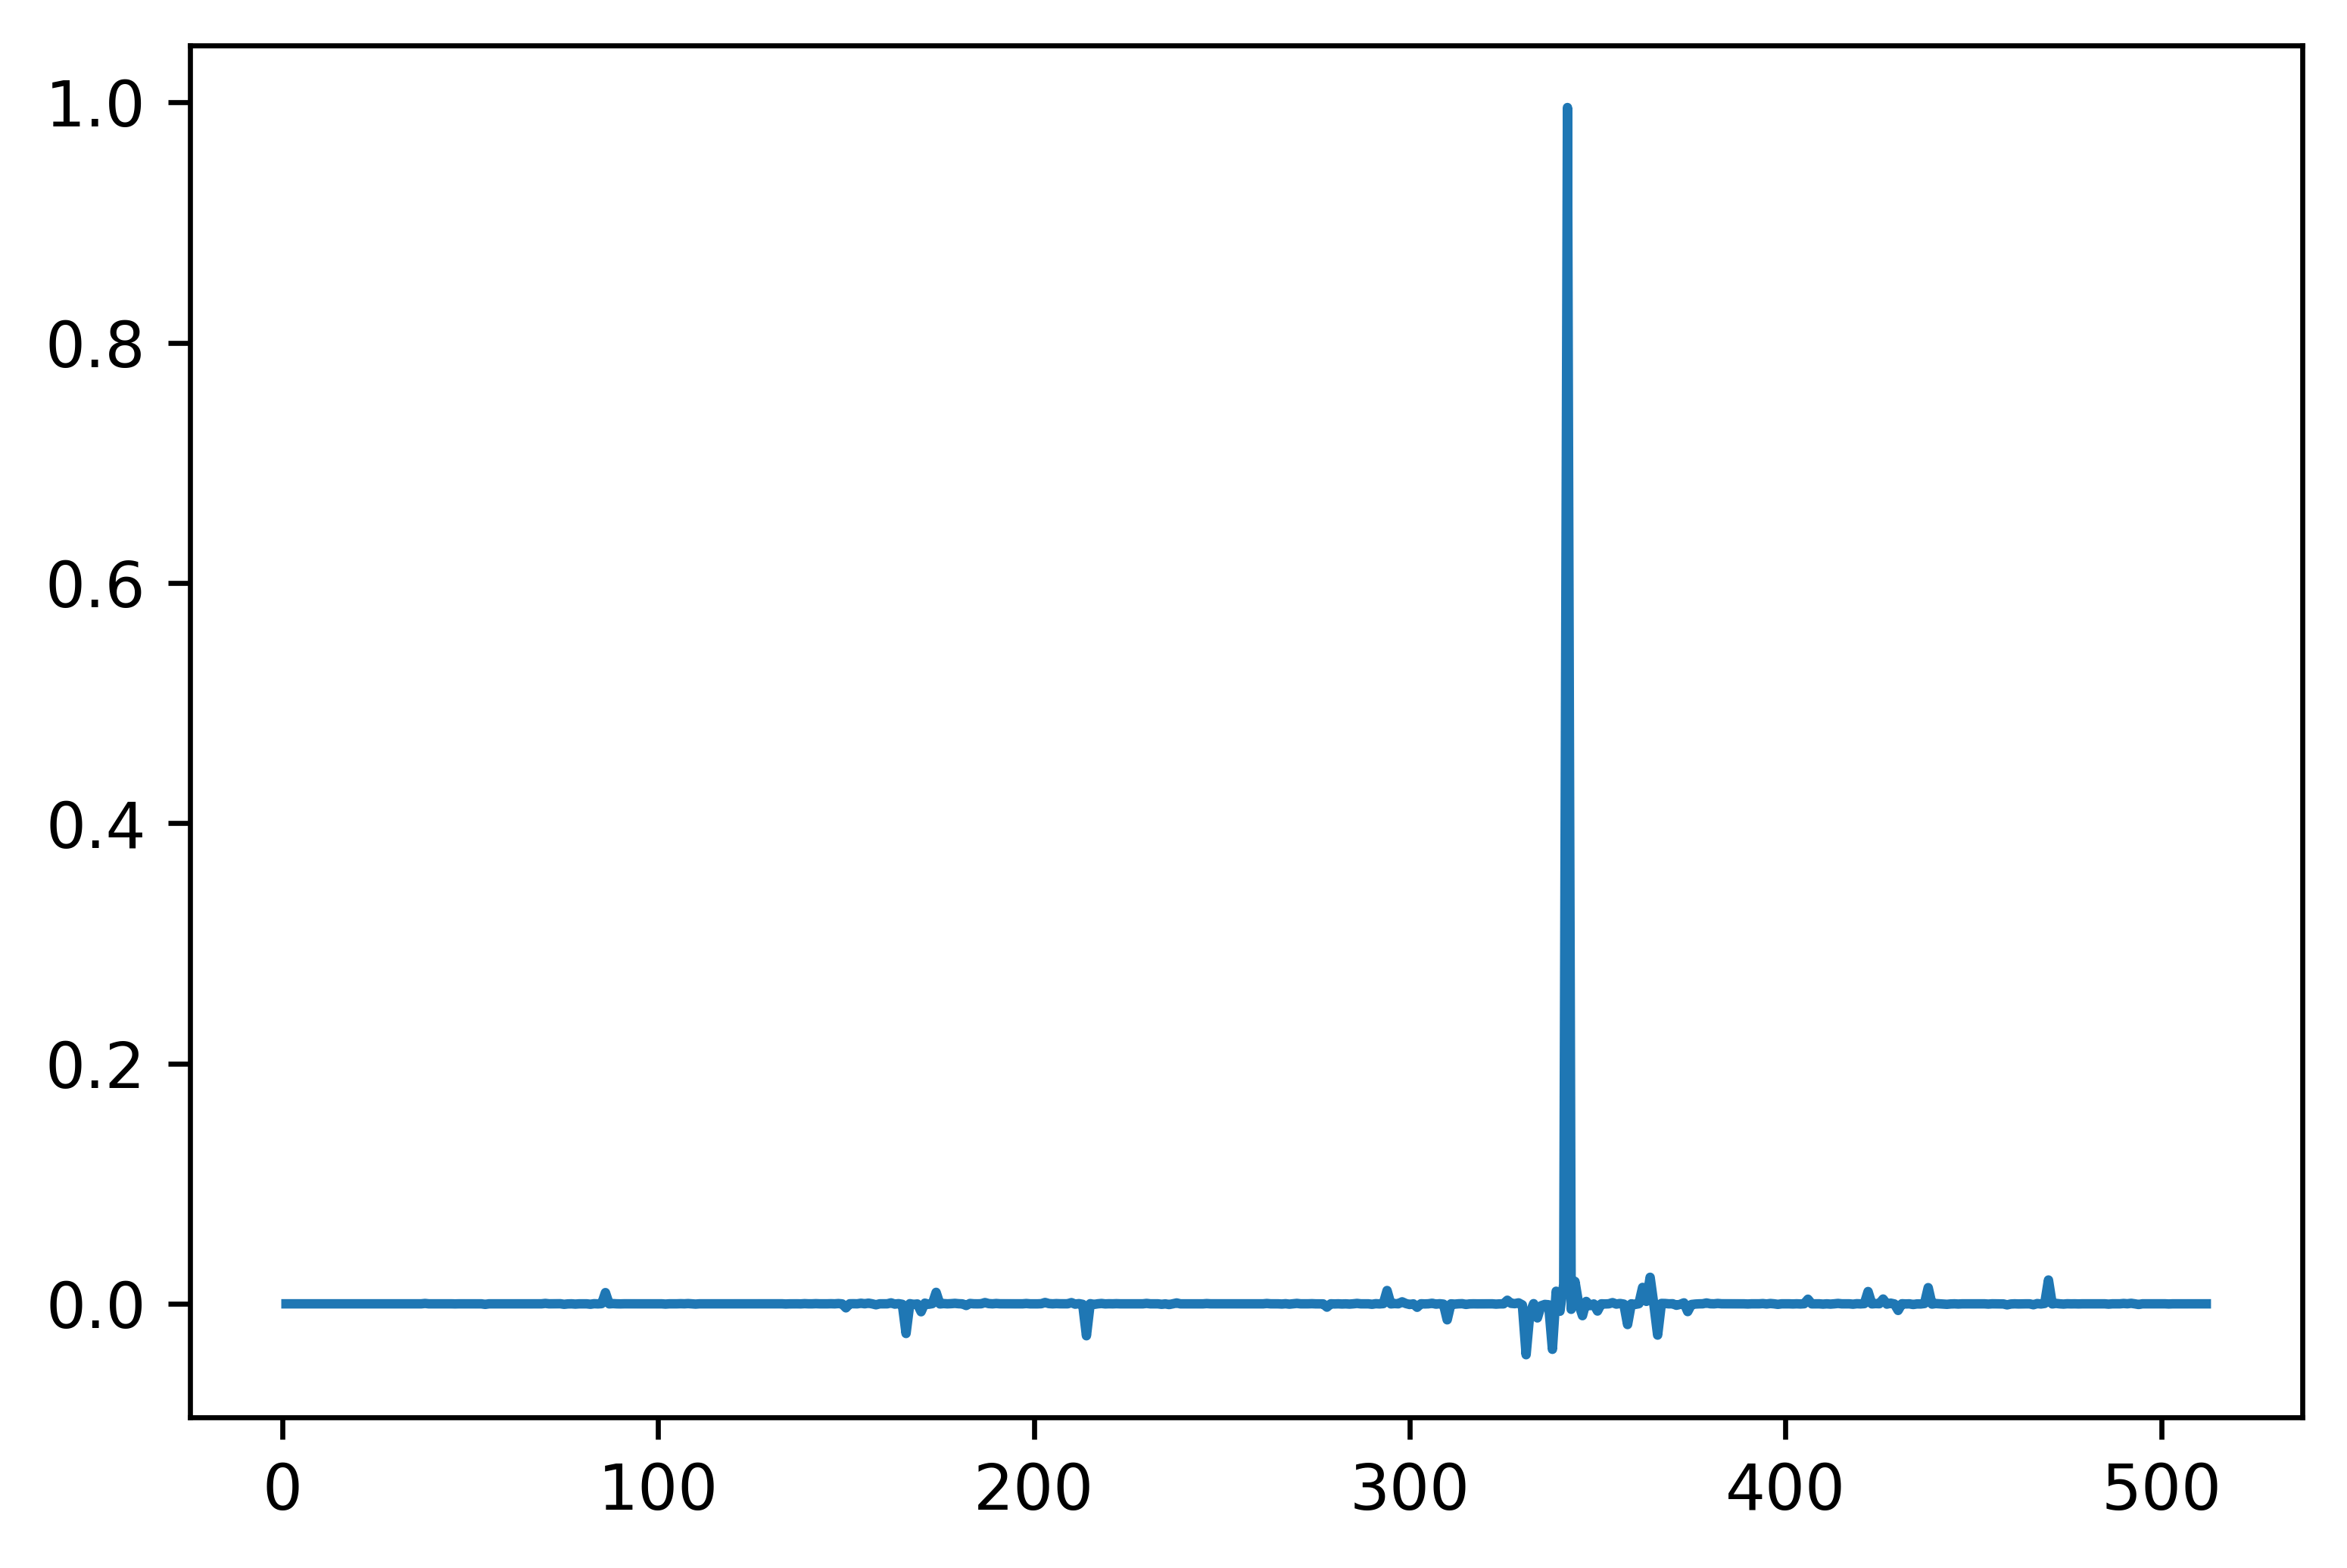


Trial 1:
energy: -5.6278097434059156
time: 3.072913885116577
max-cut objective: -11.627809743405916
solution: [1. 0. 1. 0. 1. 0. 1. 0. 1.]
solution objective: 12.0
sum of eigenstates squared:  (0.9999999999999999+0j)


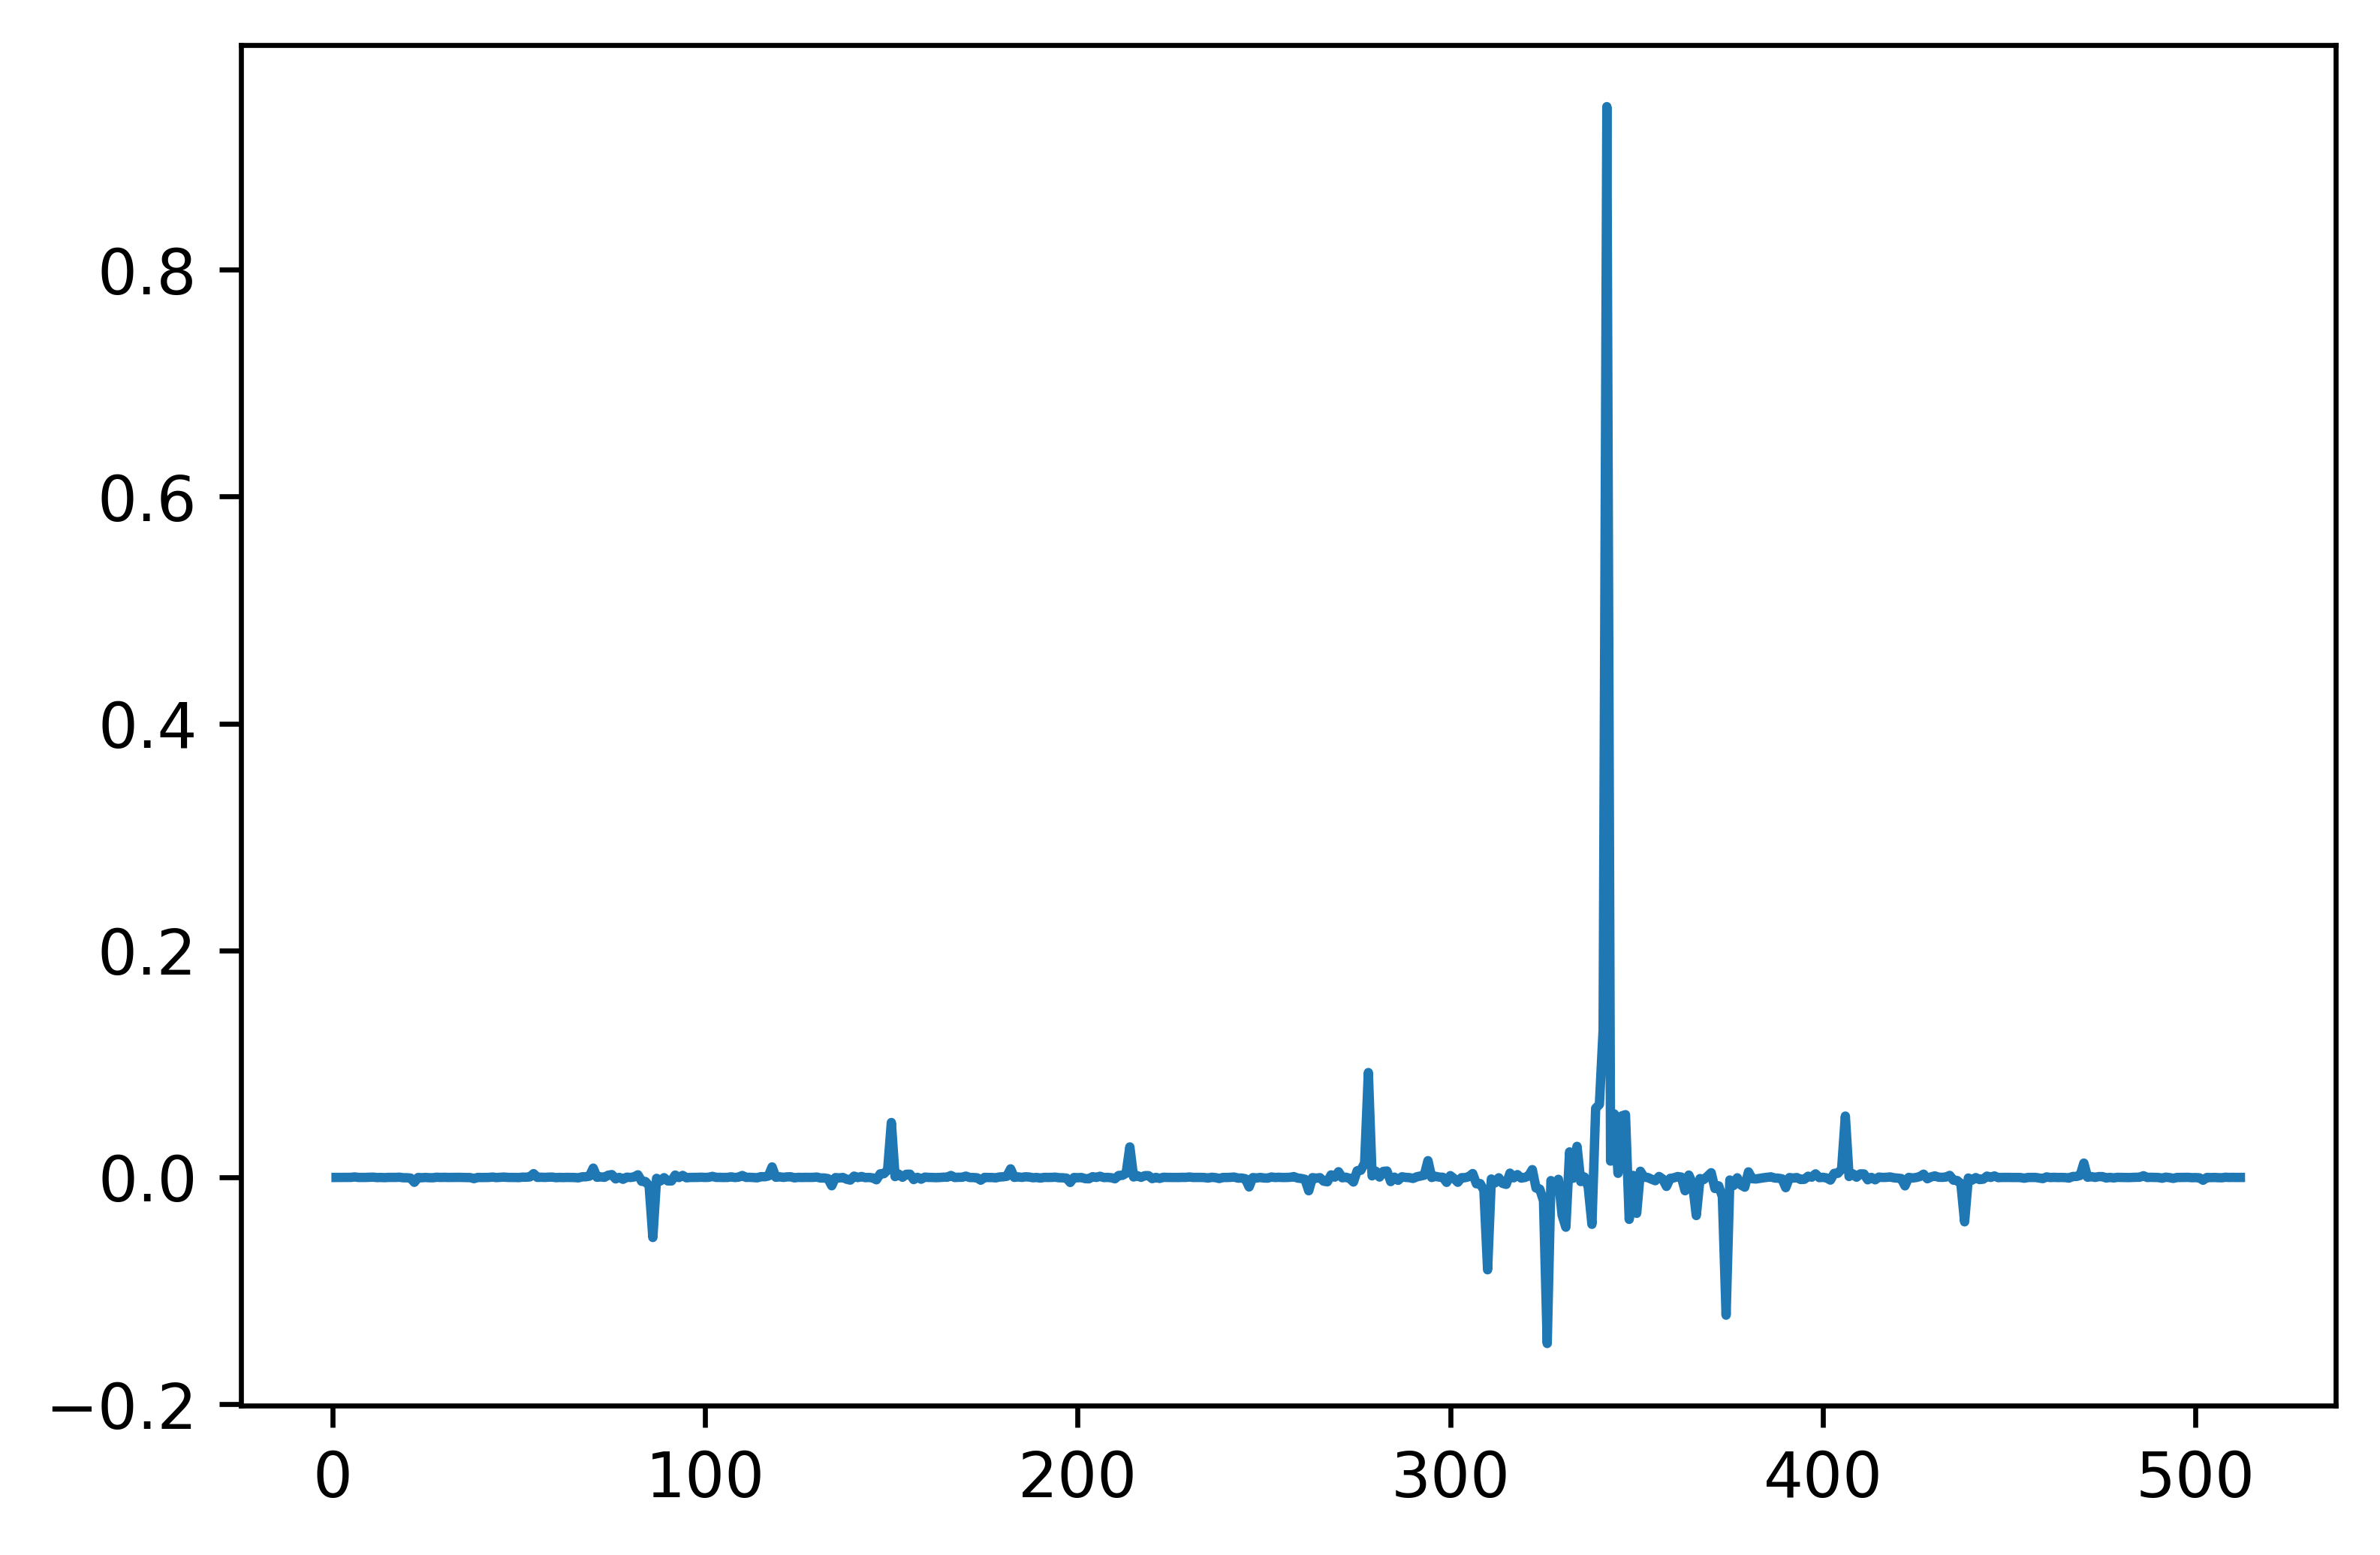


Trial 2:
energy: -5.783160156471242
time: 2.9864532947540283
max-cut objective: -11.783160156471242
solution: [0. 1. 0. 1. 0. 1. 0. 1. 0.]
solution objective: 12.0
sum of eigenstates squared:  (0.9999999999999997+0j)


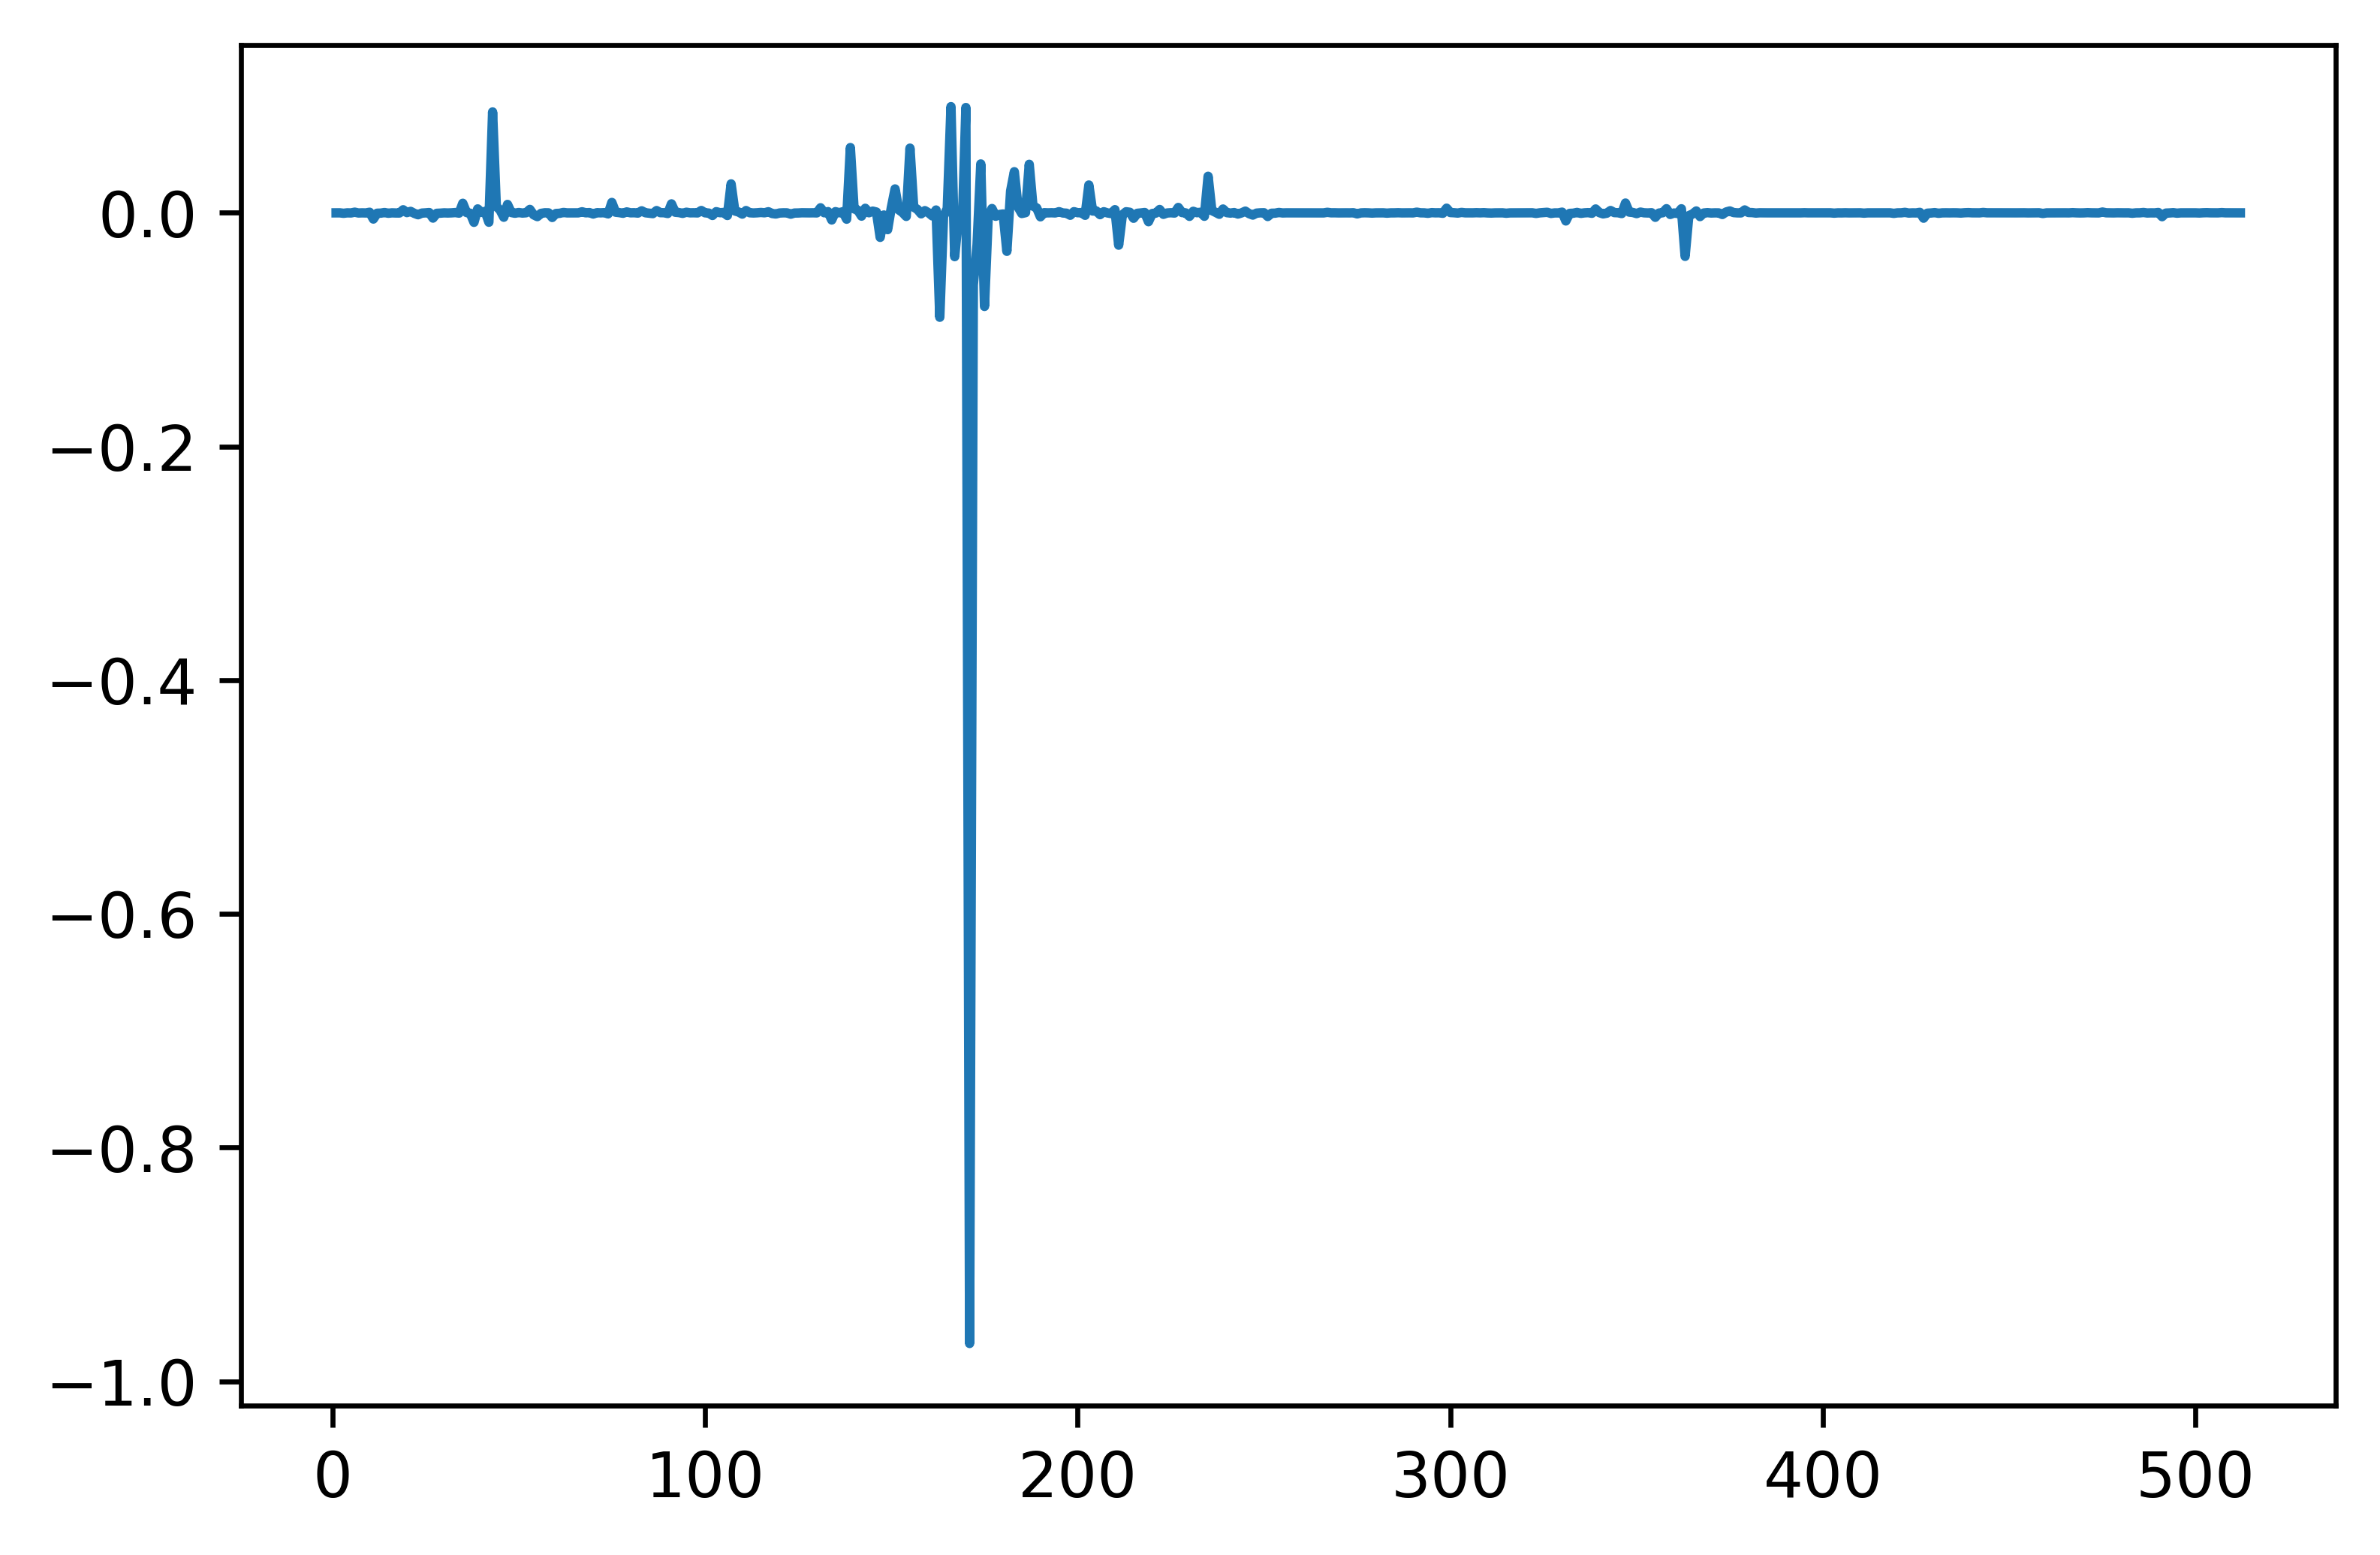


Trial 3:
energy: -5.578643658373958
time: 3.068729877471924
max-cut objective: -11.578643658373958
solution: [1. 0. 1. 0. 1. 0. 1. 0. 1.]
solution objective: 12.0
sum of eigenstates squared:  (0.9999999999999984+0j)


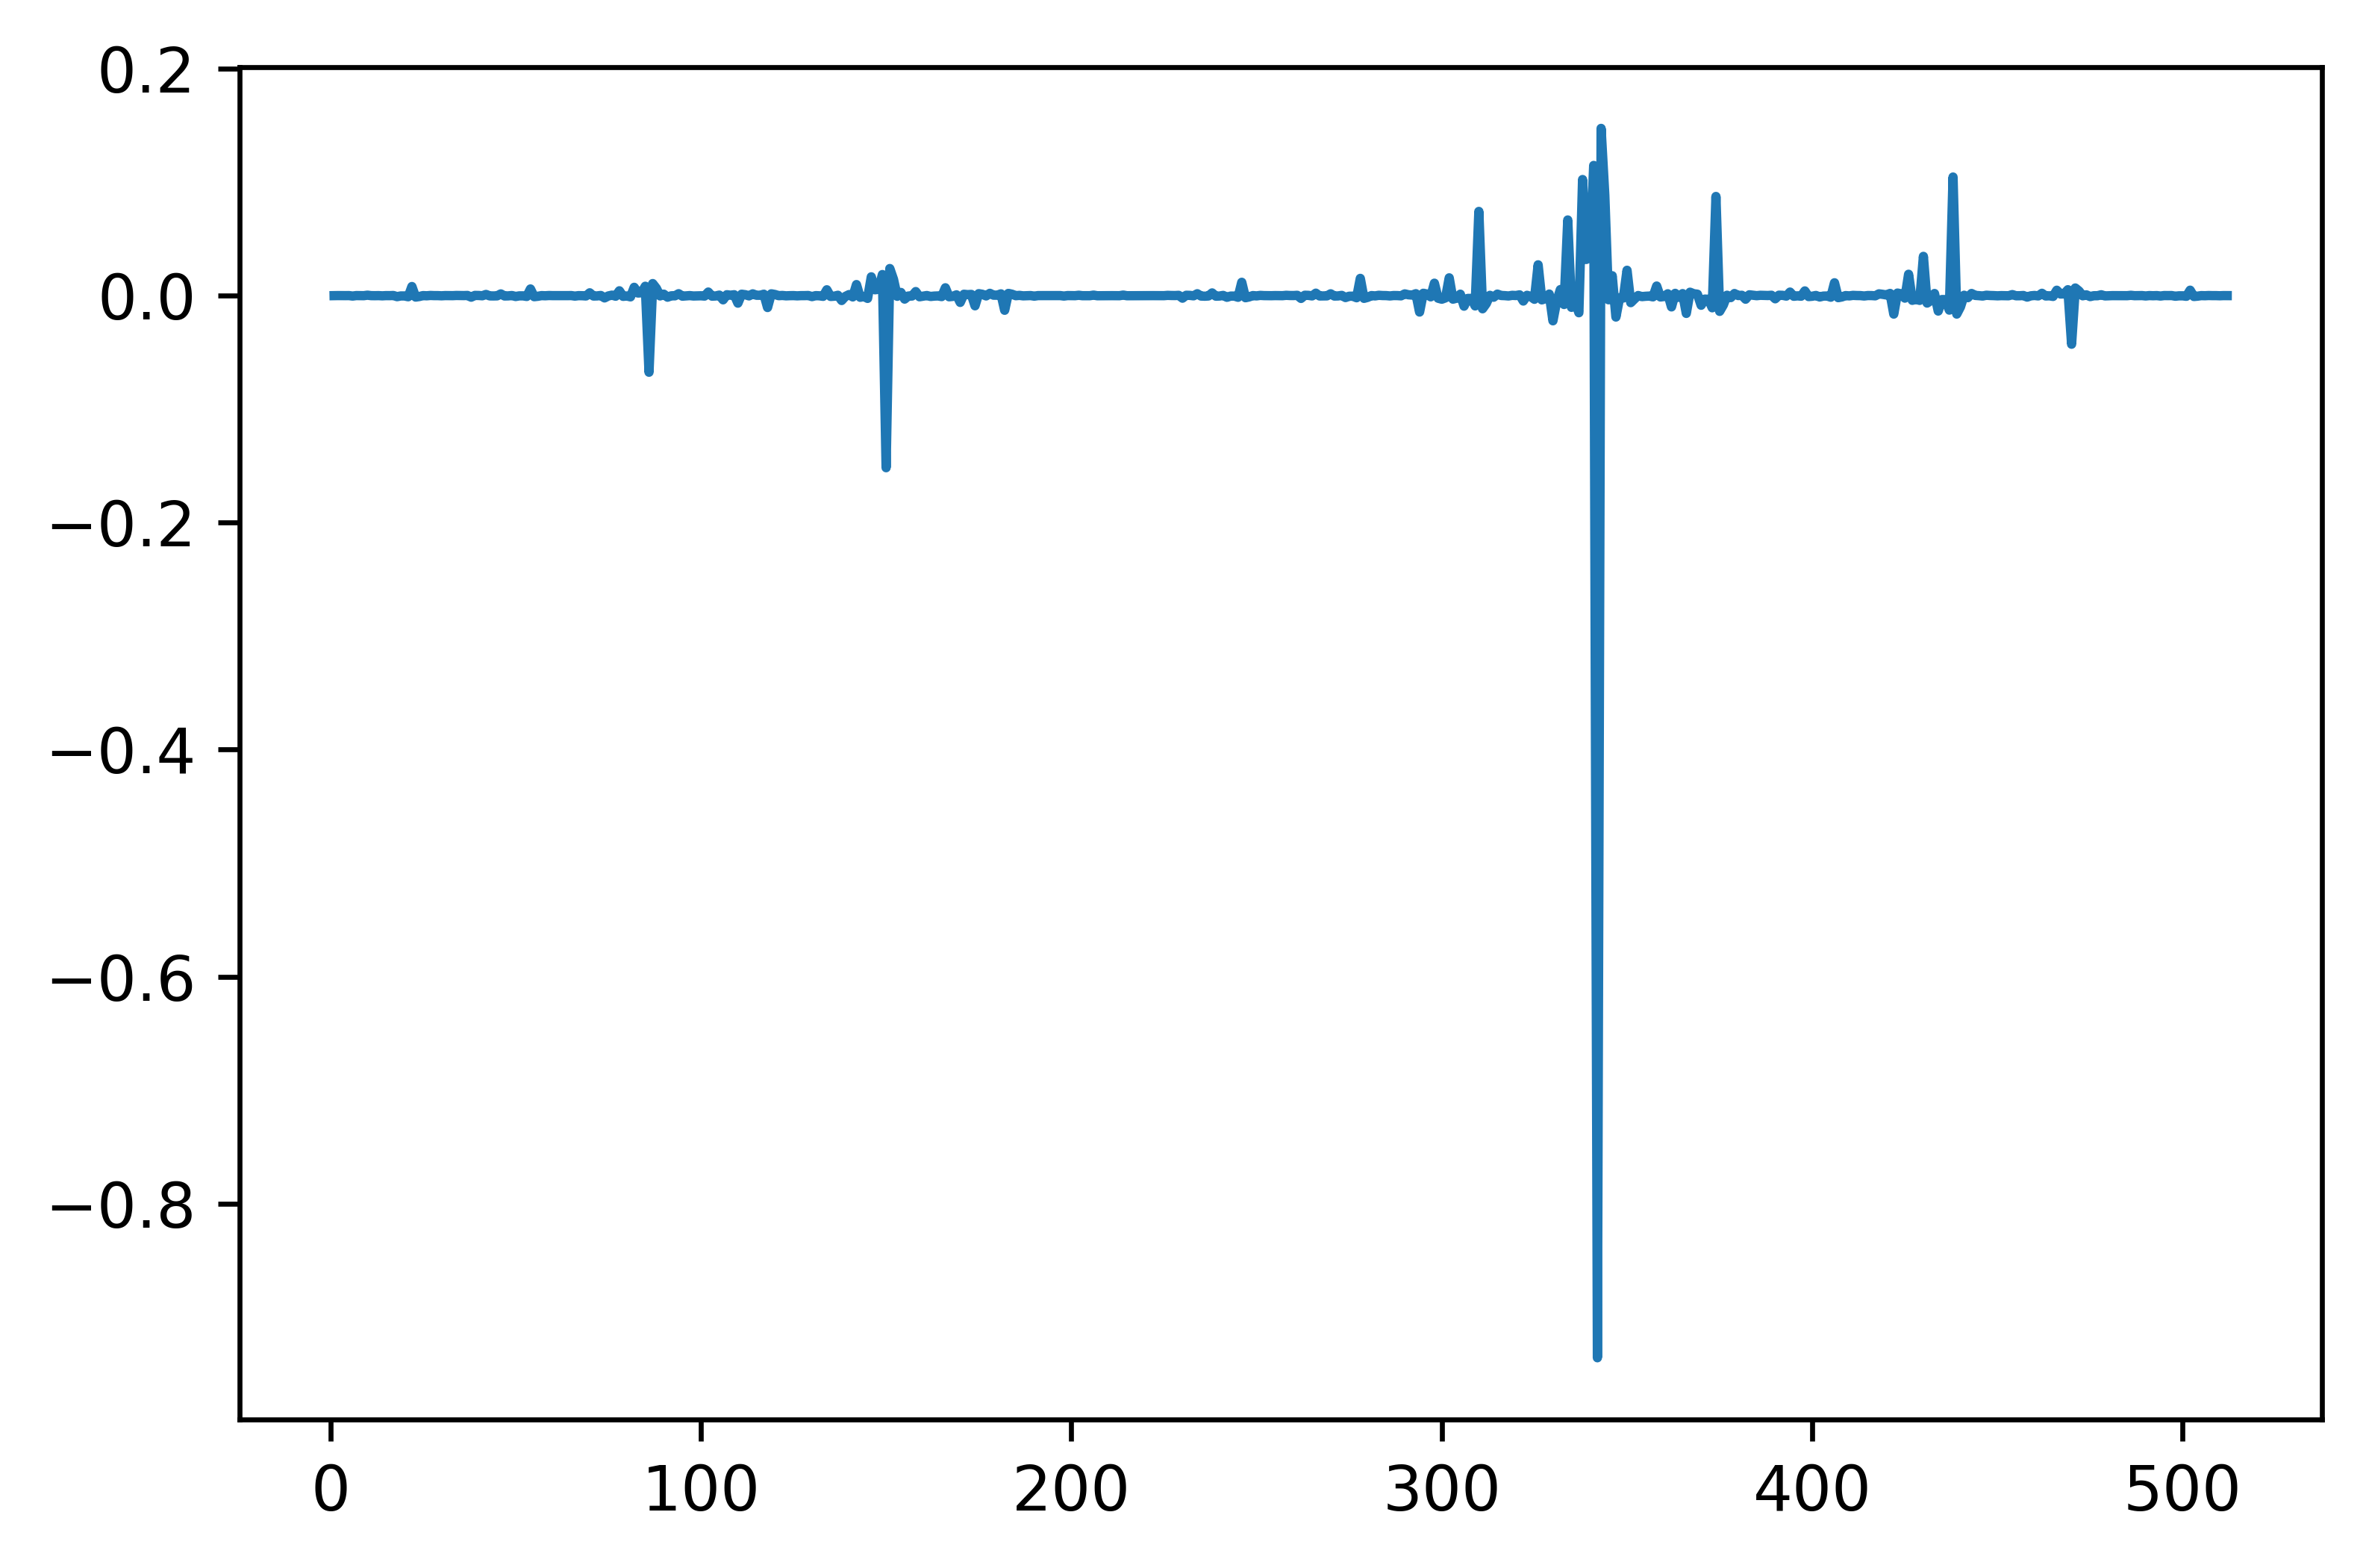


Trial 4:
energy: -5.857431181399954
time: 3.1022329330444336
max-cut objective: -11.857431181399953
solution: [0. 1. 0. 1. 0. 1. 0. 1. 0.]
solution objective: 12.0
sum of eigenstates squared:  (0.9999999999999999+0j)


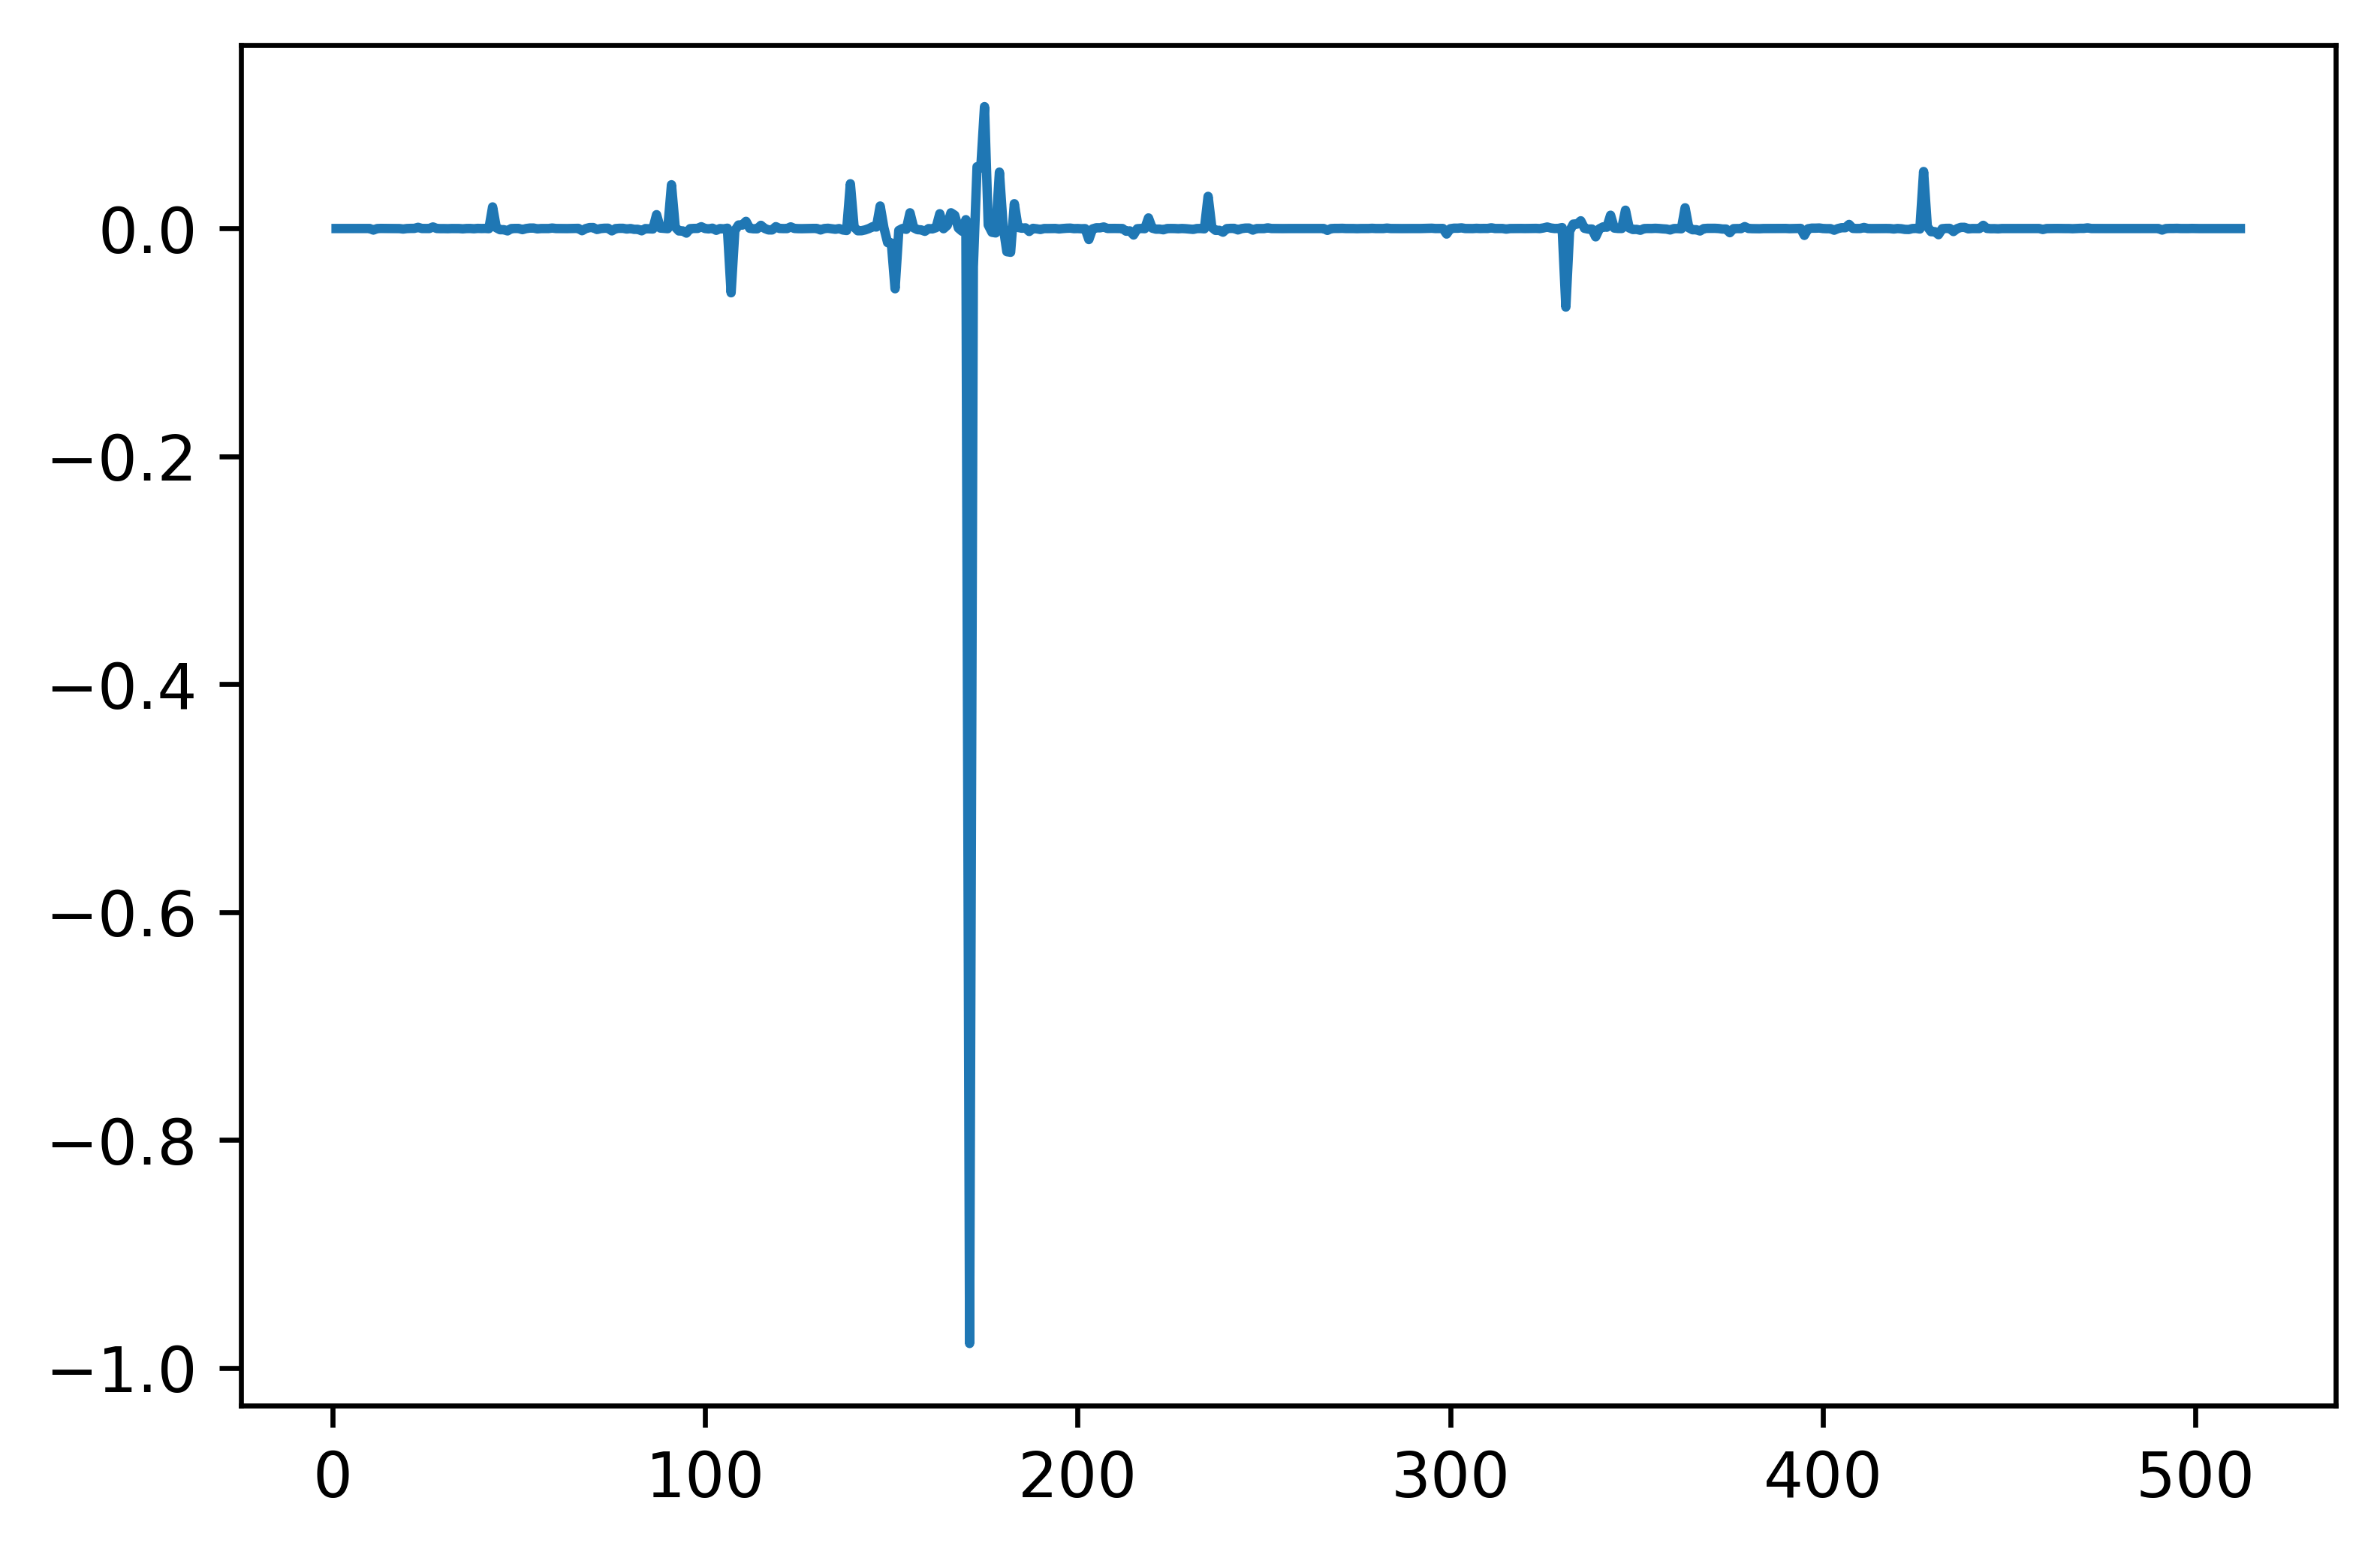


Trial 5:
energy: -5.828081500287348
time: 3.0313117504119873
max-cut objective: -11.828081500287347
solution: [0. 1. 0. 1. 0. 1. 0. 1. 0.]
solution objective: 12.0
sum of eigenstates squared:  (0.9999999999999996+0j)


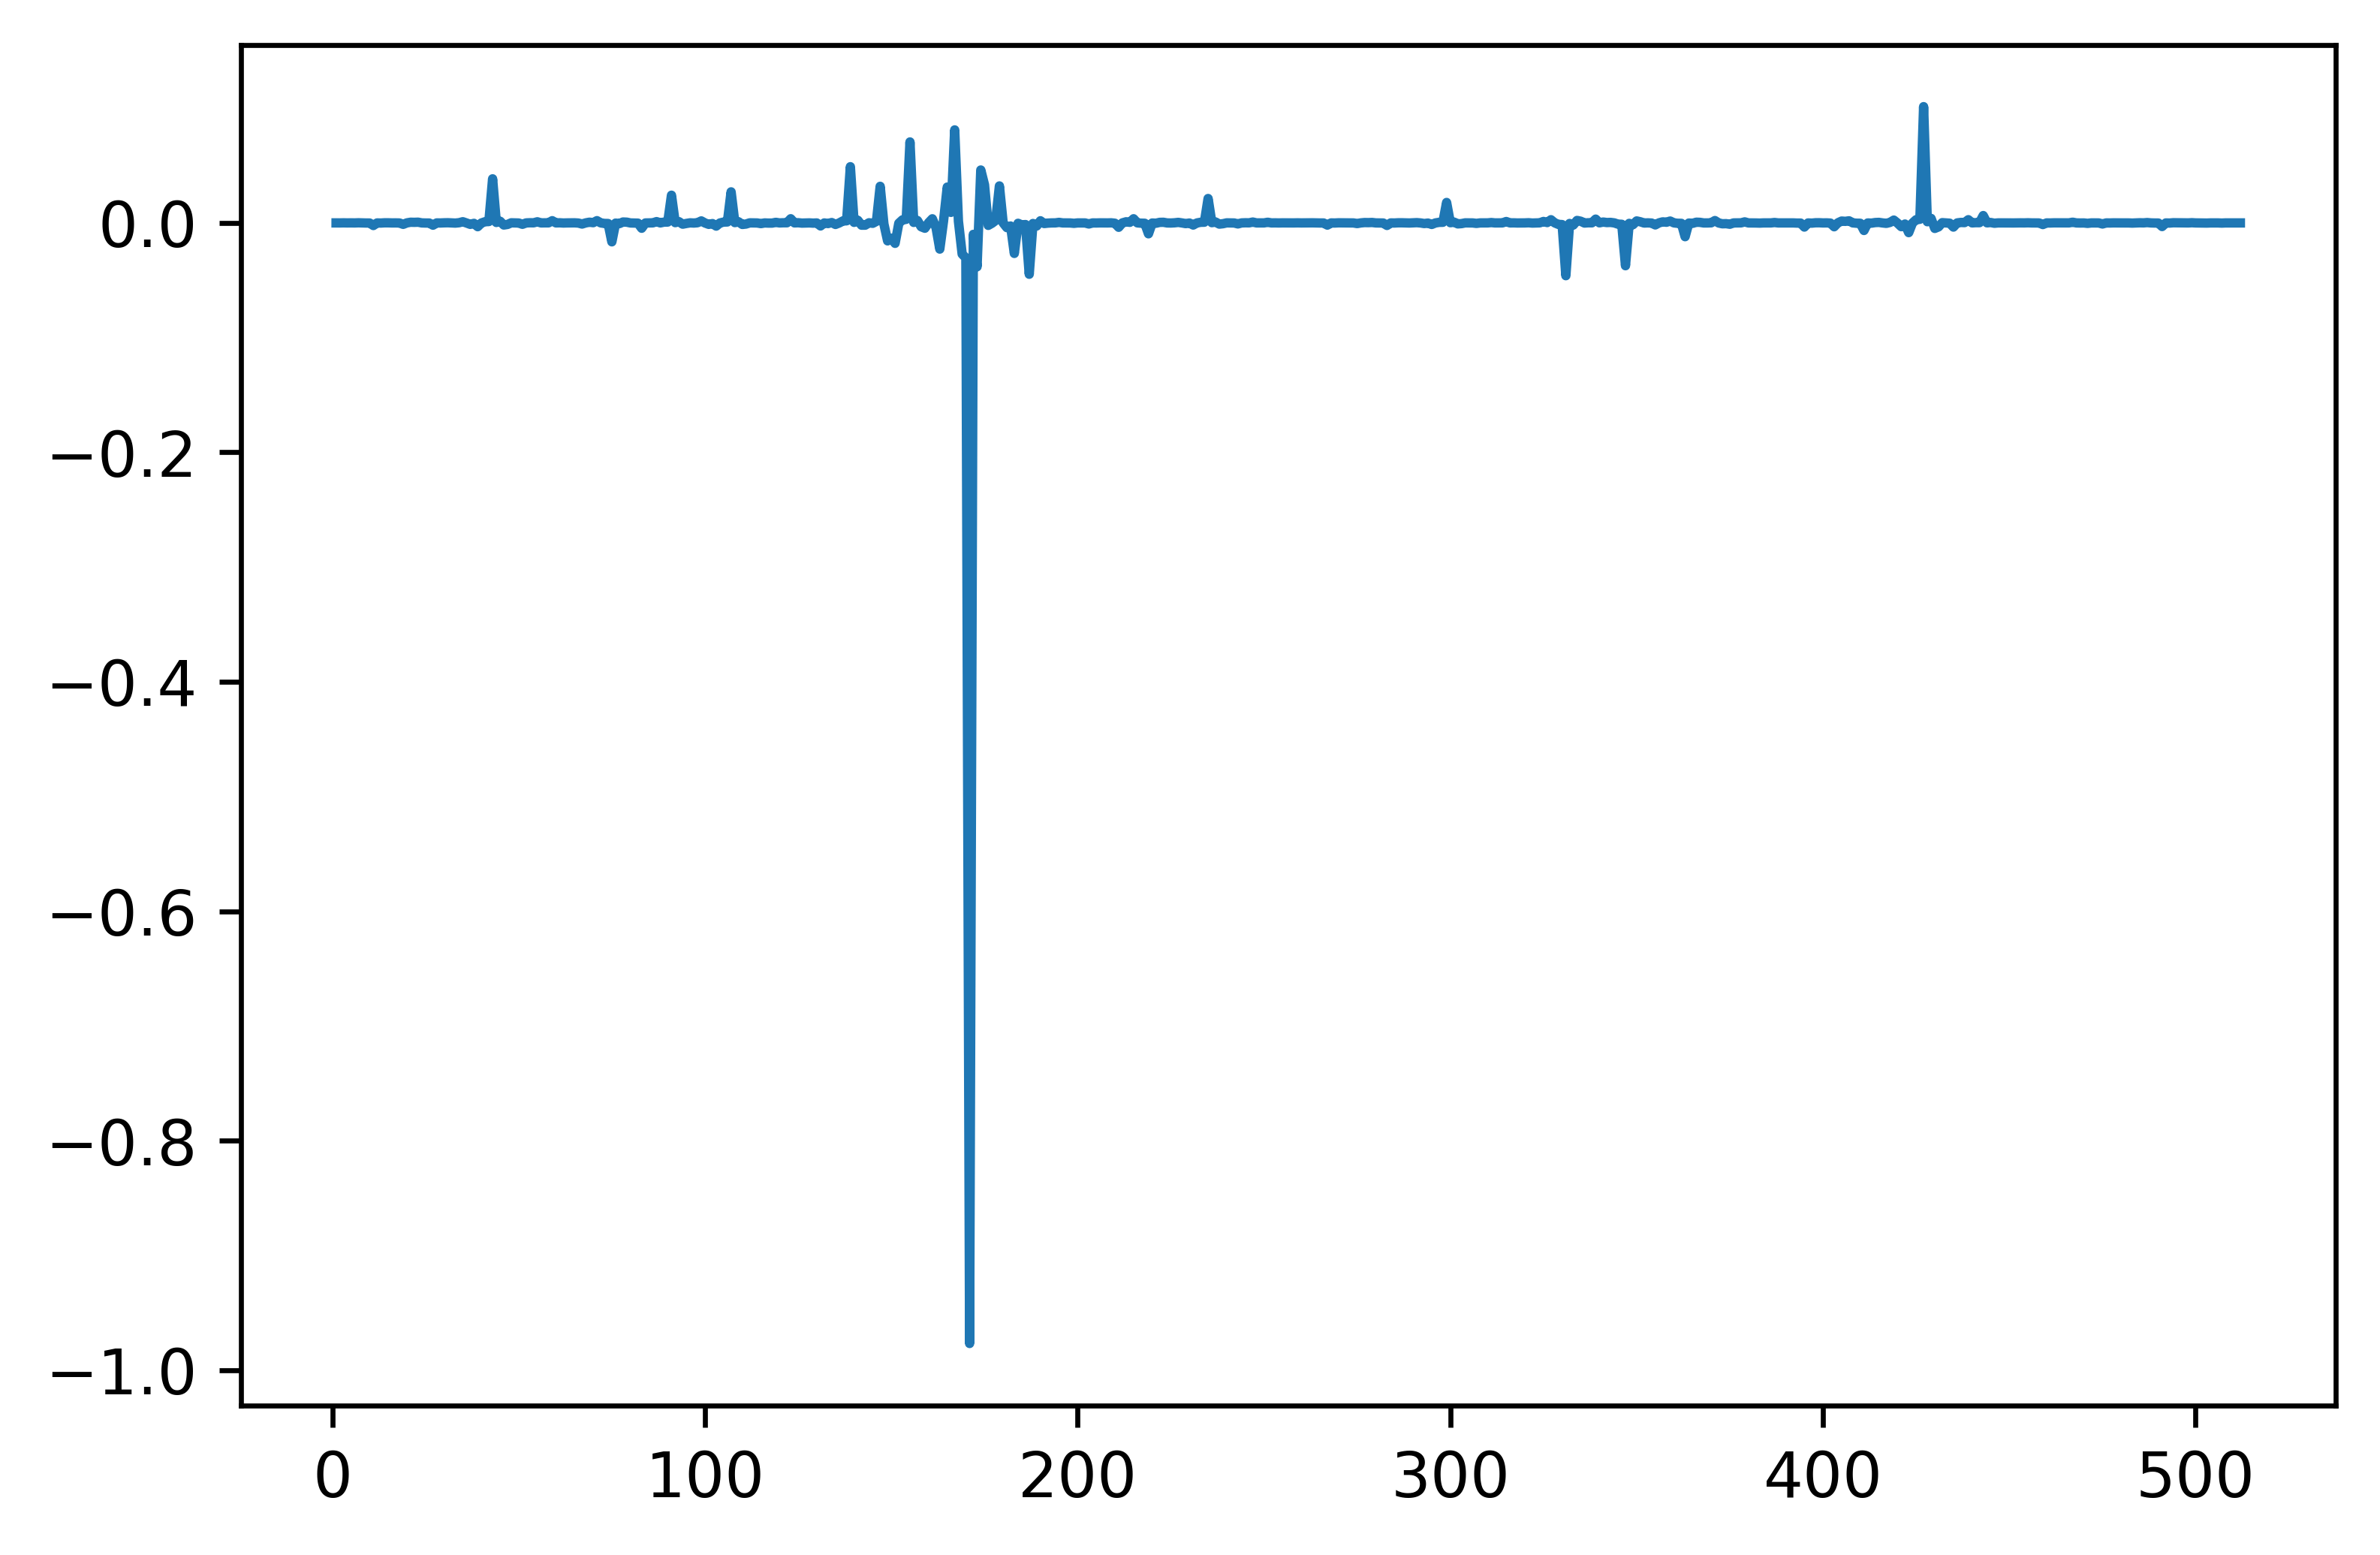


Trial 6:
energy: -5.6442265382948
time: 3.1047511100769043
max-cut objective: -11.644226538294799
solution: [1. 0. 1. 0. 1. 0. 1. 0. 1.]
solution objective: 12.0
sum of eigenstates squared:  (0.9999999999999997+0j)


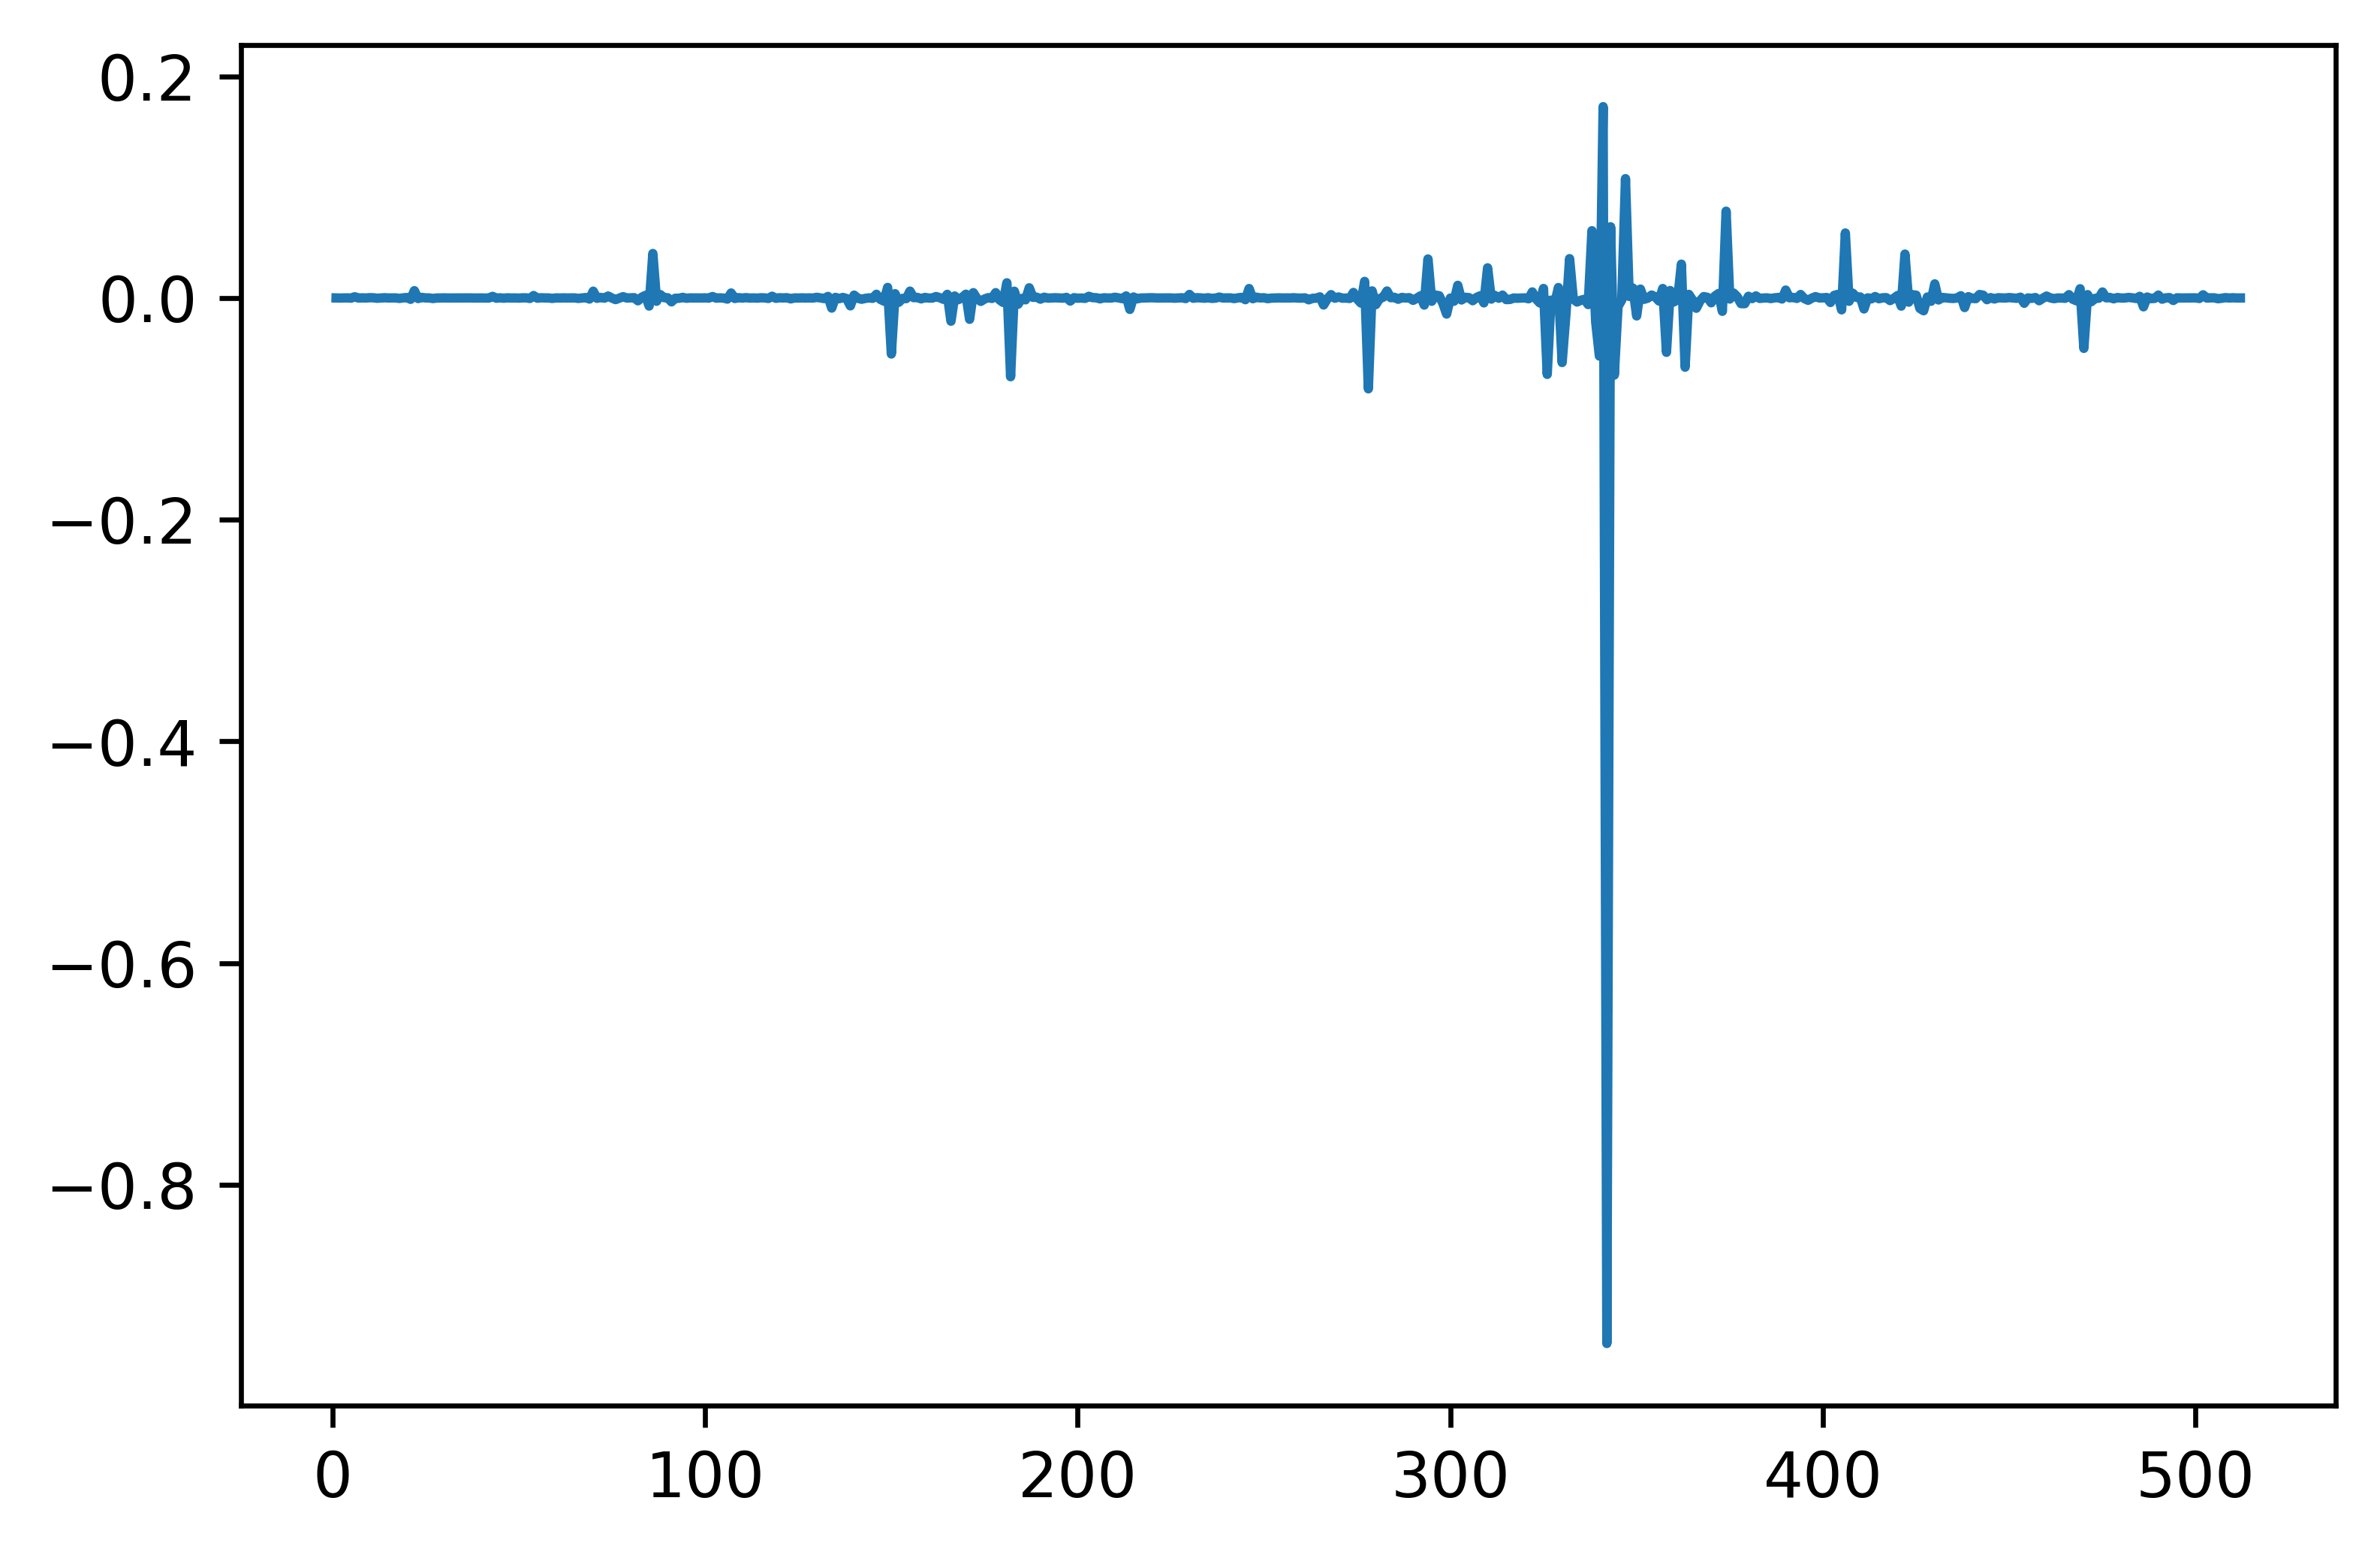


Trial 7:
energy: -5.9712412254992895
time: 3.075029134750366
max-cut objective: -11.97124122549929
solution: [0. 1. 0. 1. 0. 1. 0. 1. 0.]
solution objective: 12.0
sum of eigenstates squared:  (0.9999999999999994+0j)


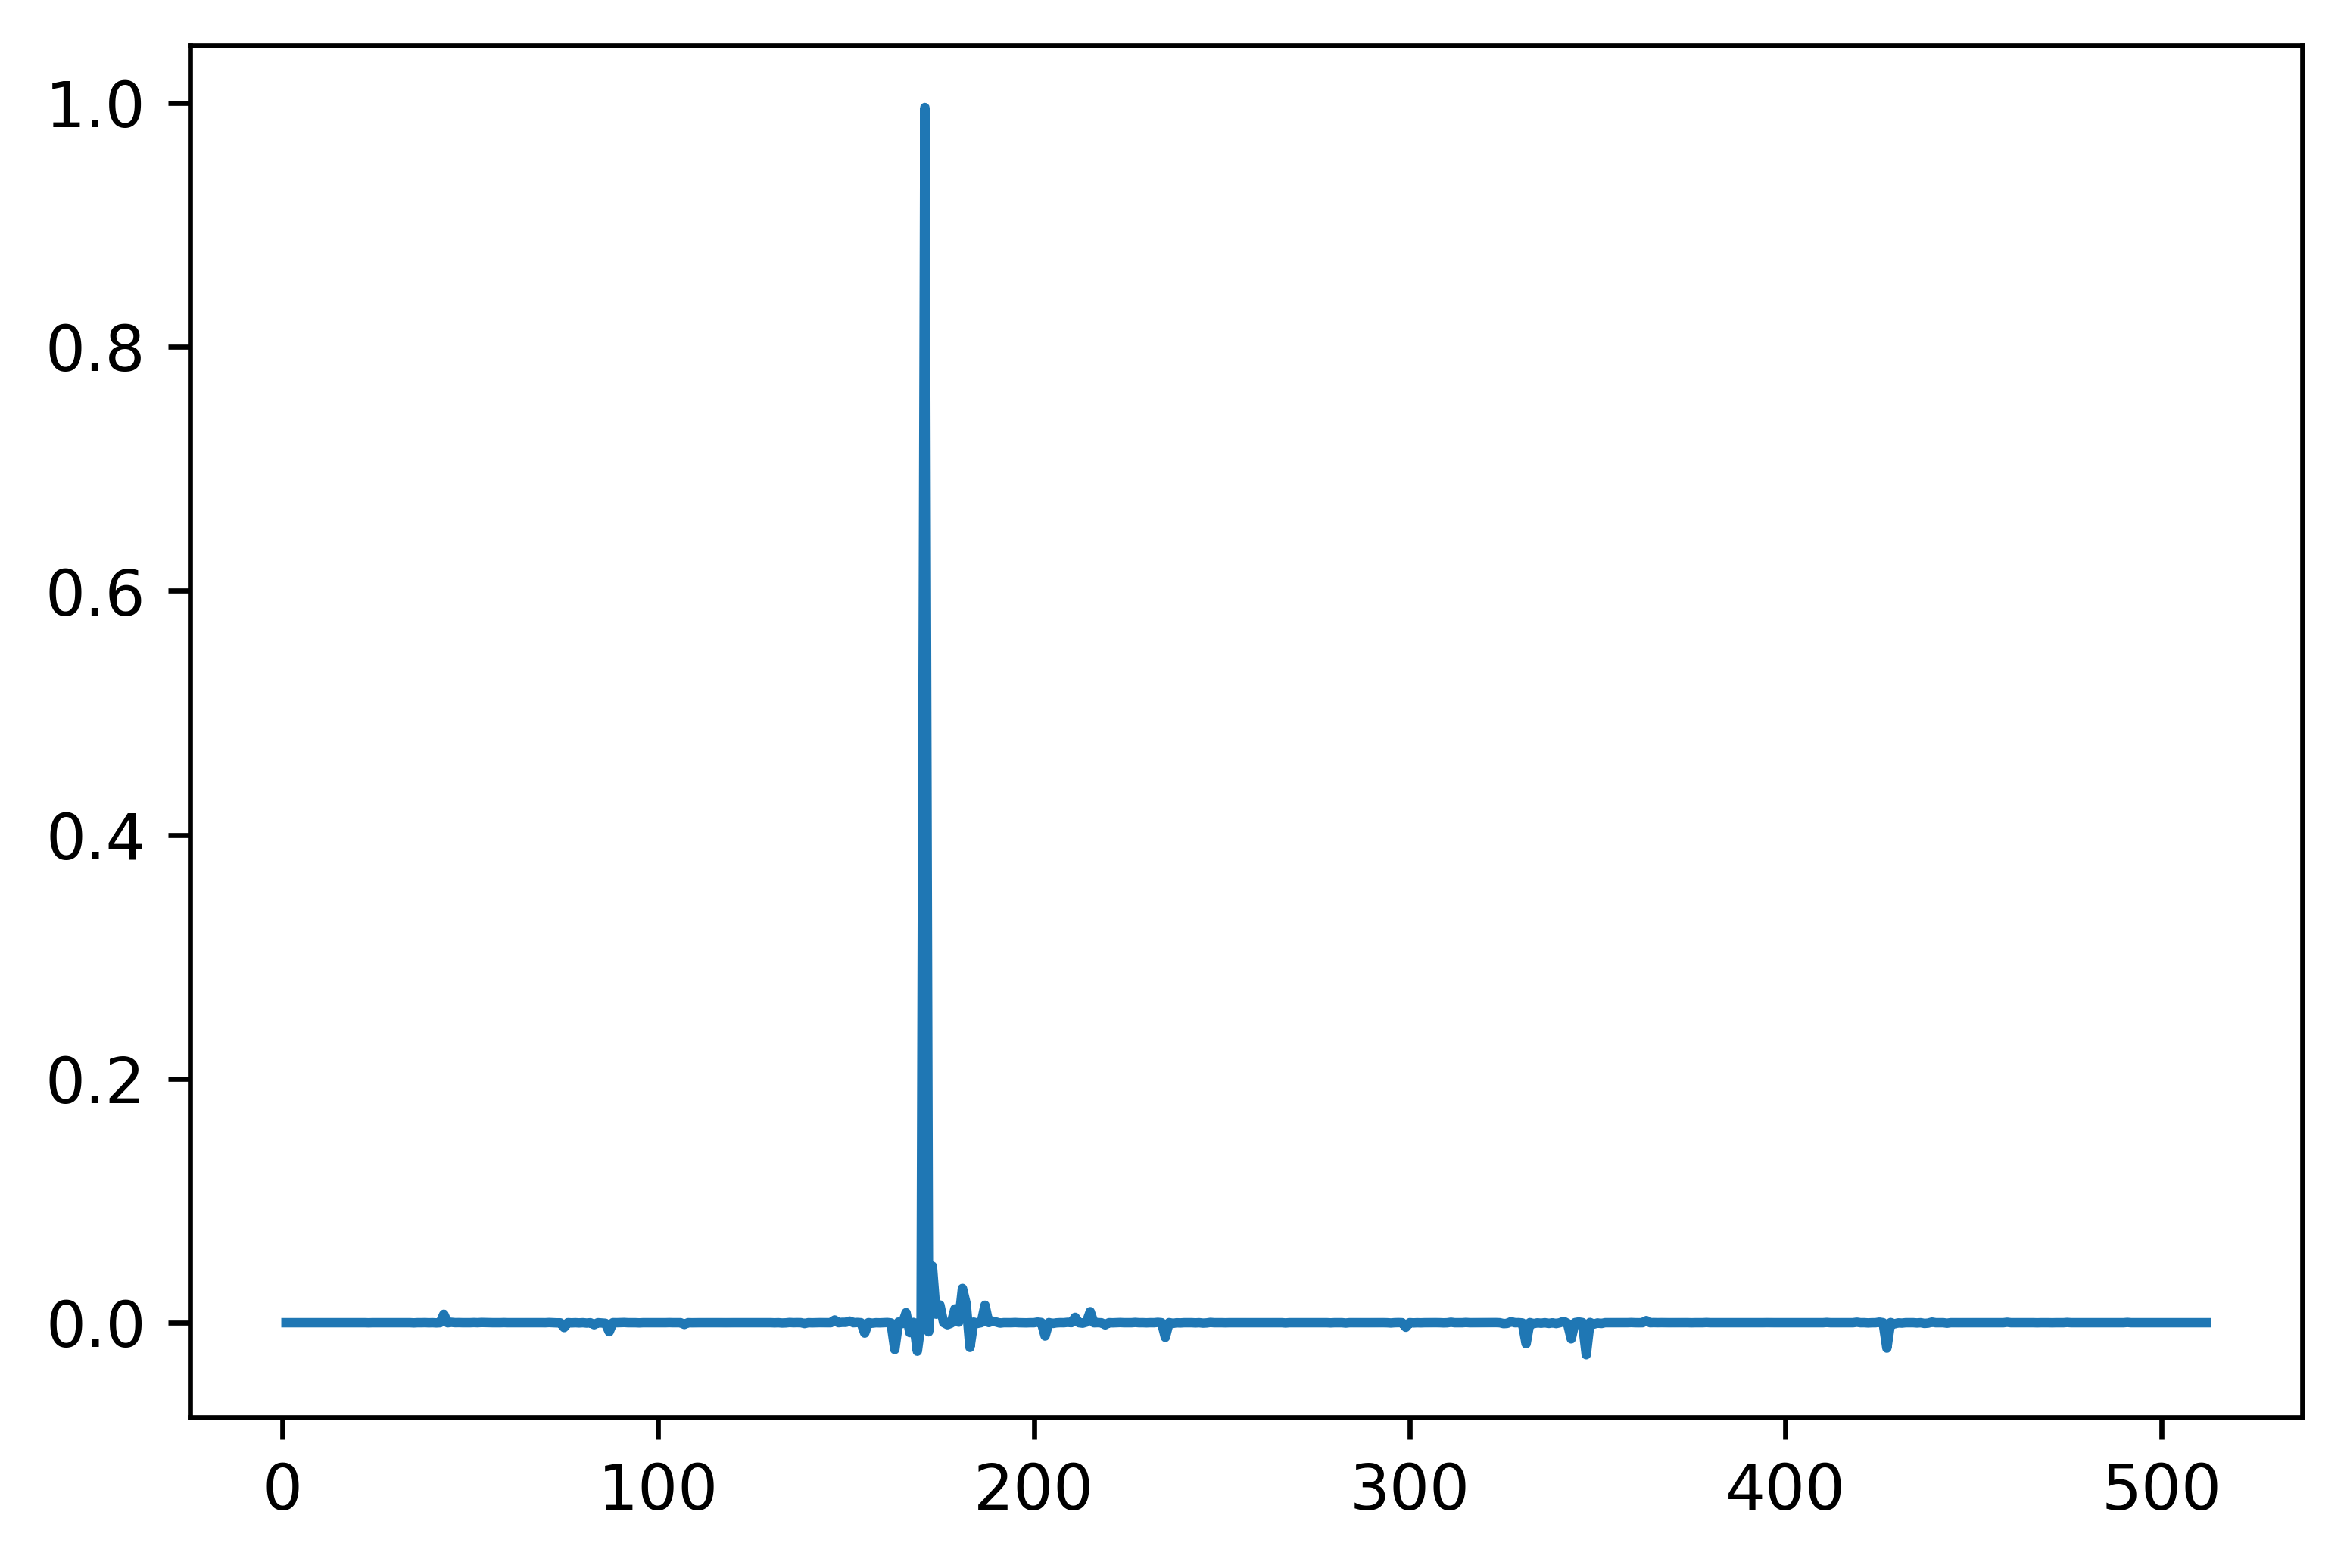


Trial 8:
energy: -5.438543077919858
time: 3.269392967224121
max-cut objective: -11.438543077919858
solution: [0. 1. 0. 1. 0. 1. 0. 1. 0.]
solution objective: 12.0
sum of eigenstates squared:  (0.9999999999999999+0j)


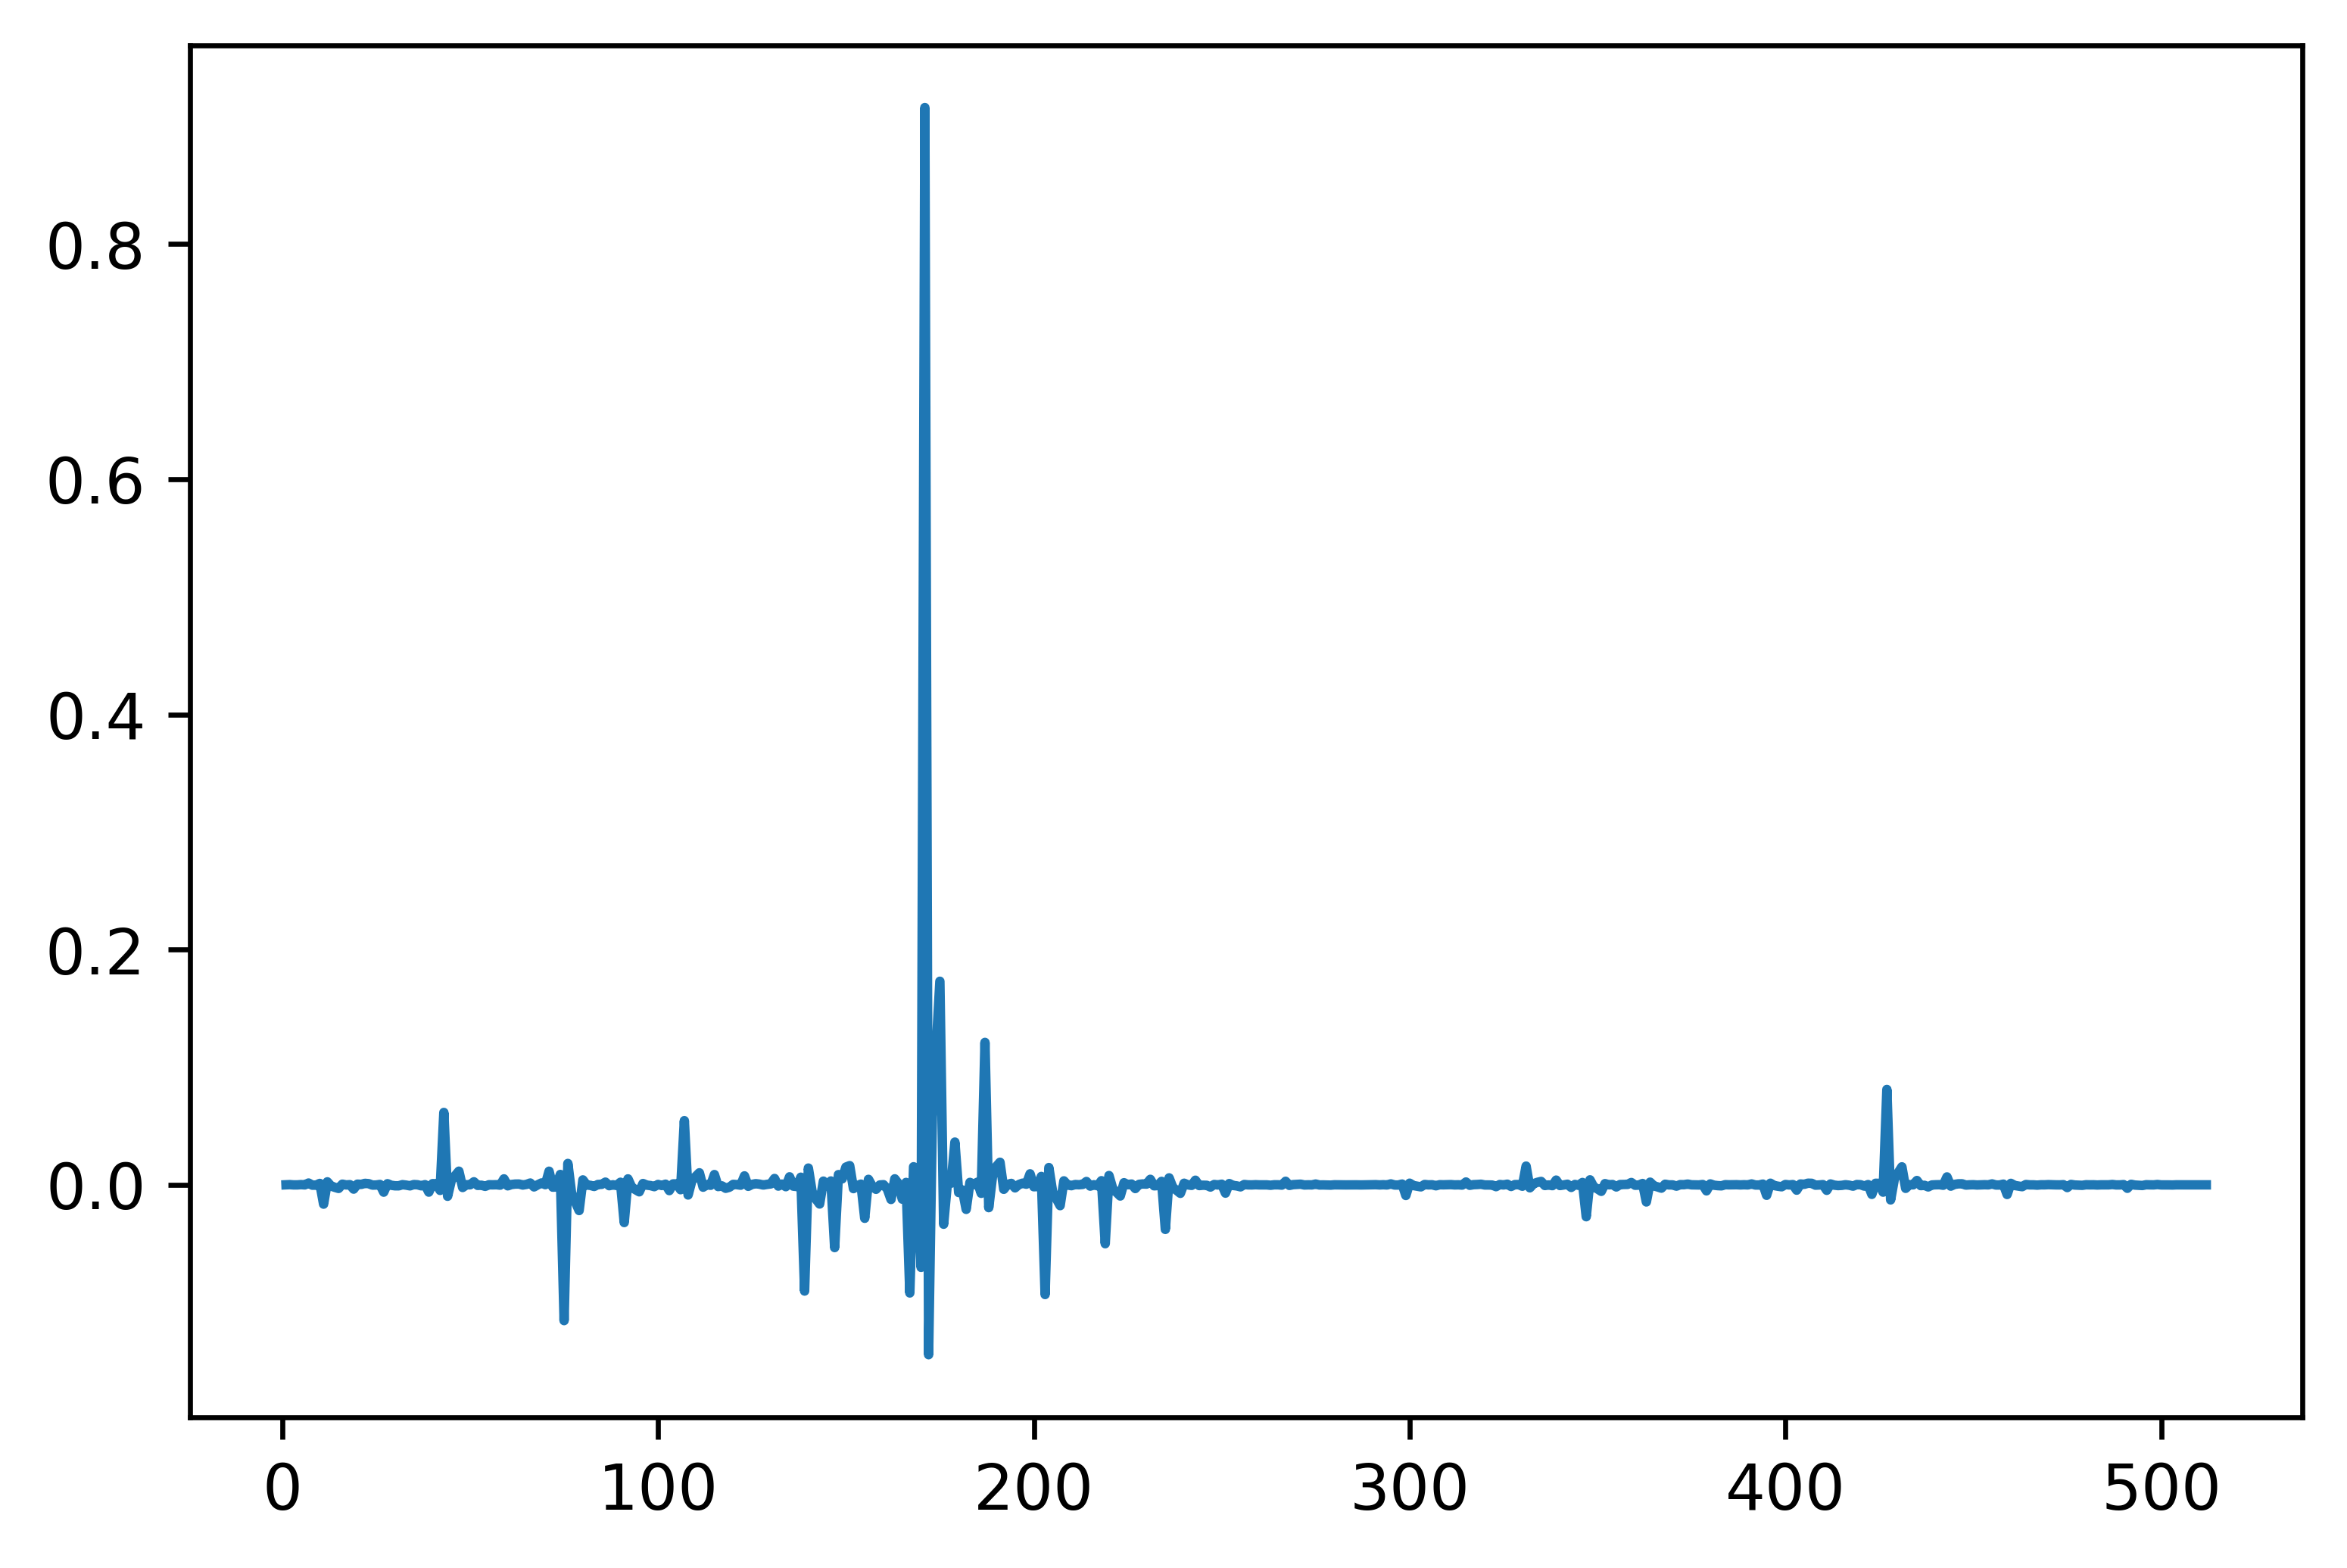


Trial 9:
energy: -5.428102270815342
time: 3.203320026397705
max-cut objective: -11.42810227081534
solution: [1. 0. 1. 0. 1. 0. 1. 0. 1.]
solution objective: 12.0
sum of eigenstates squared:  (1.000000000000001+0j)


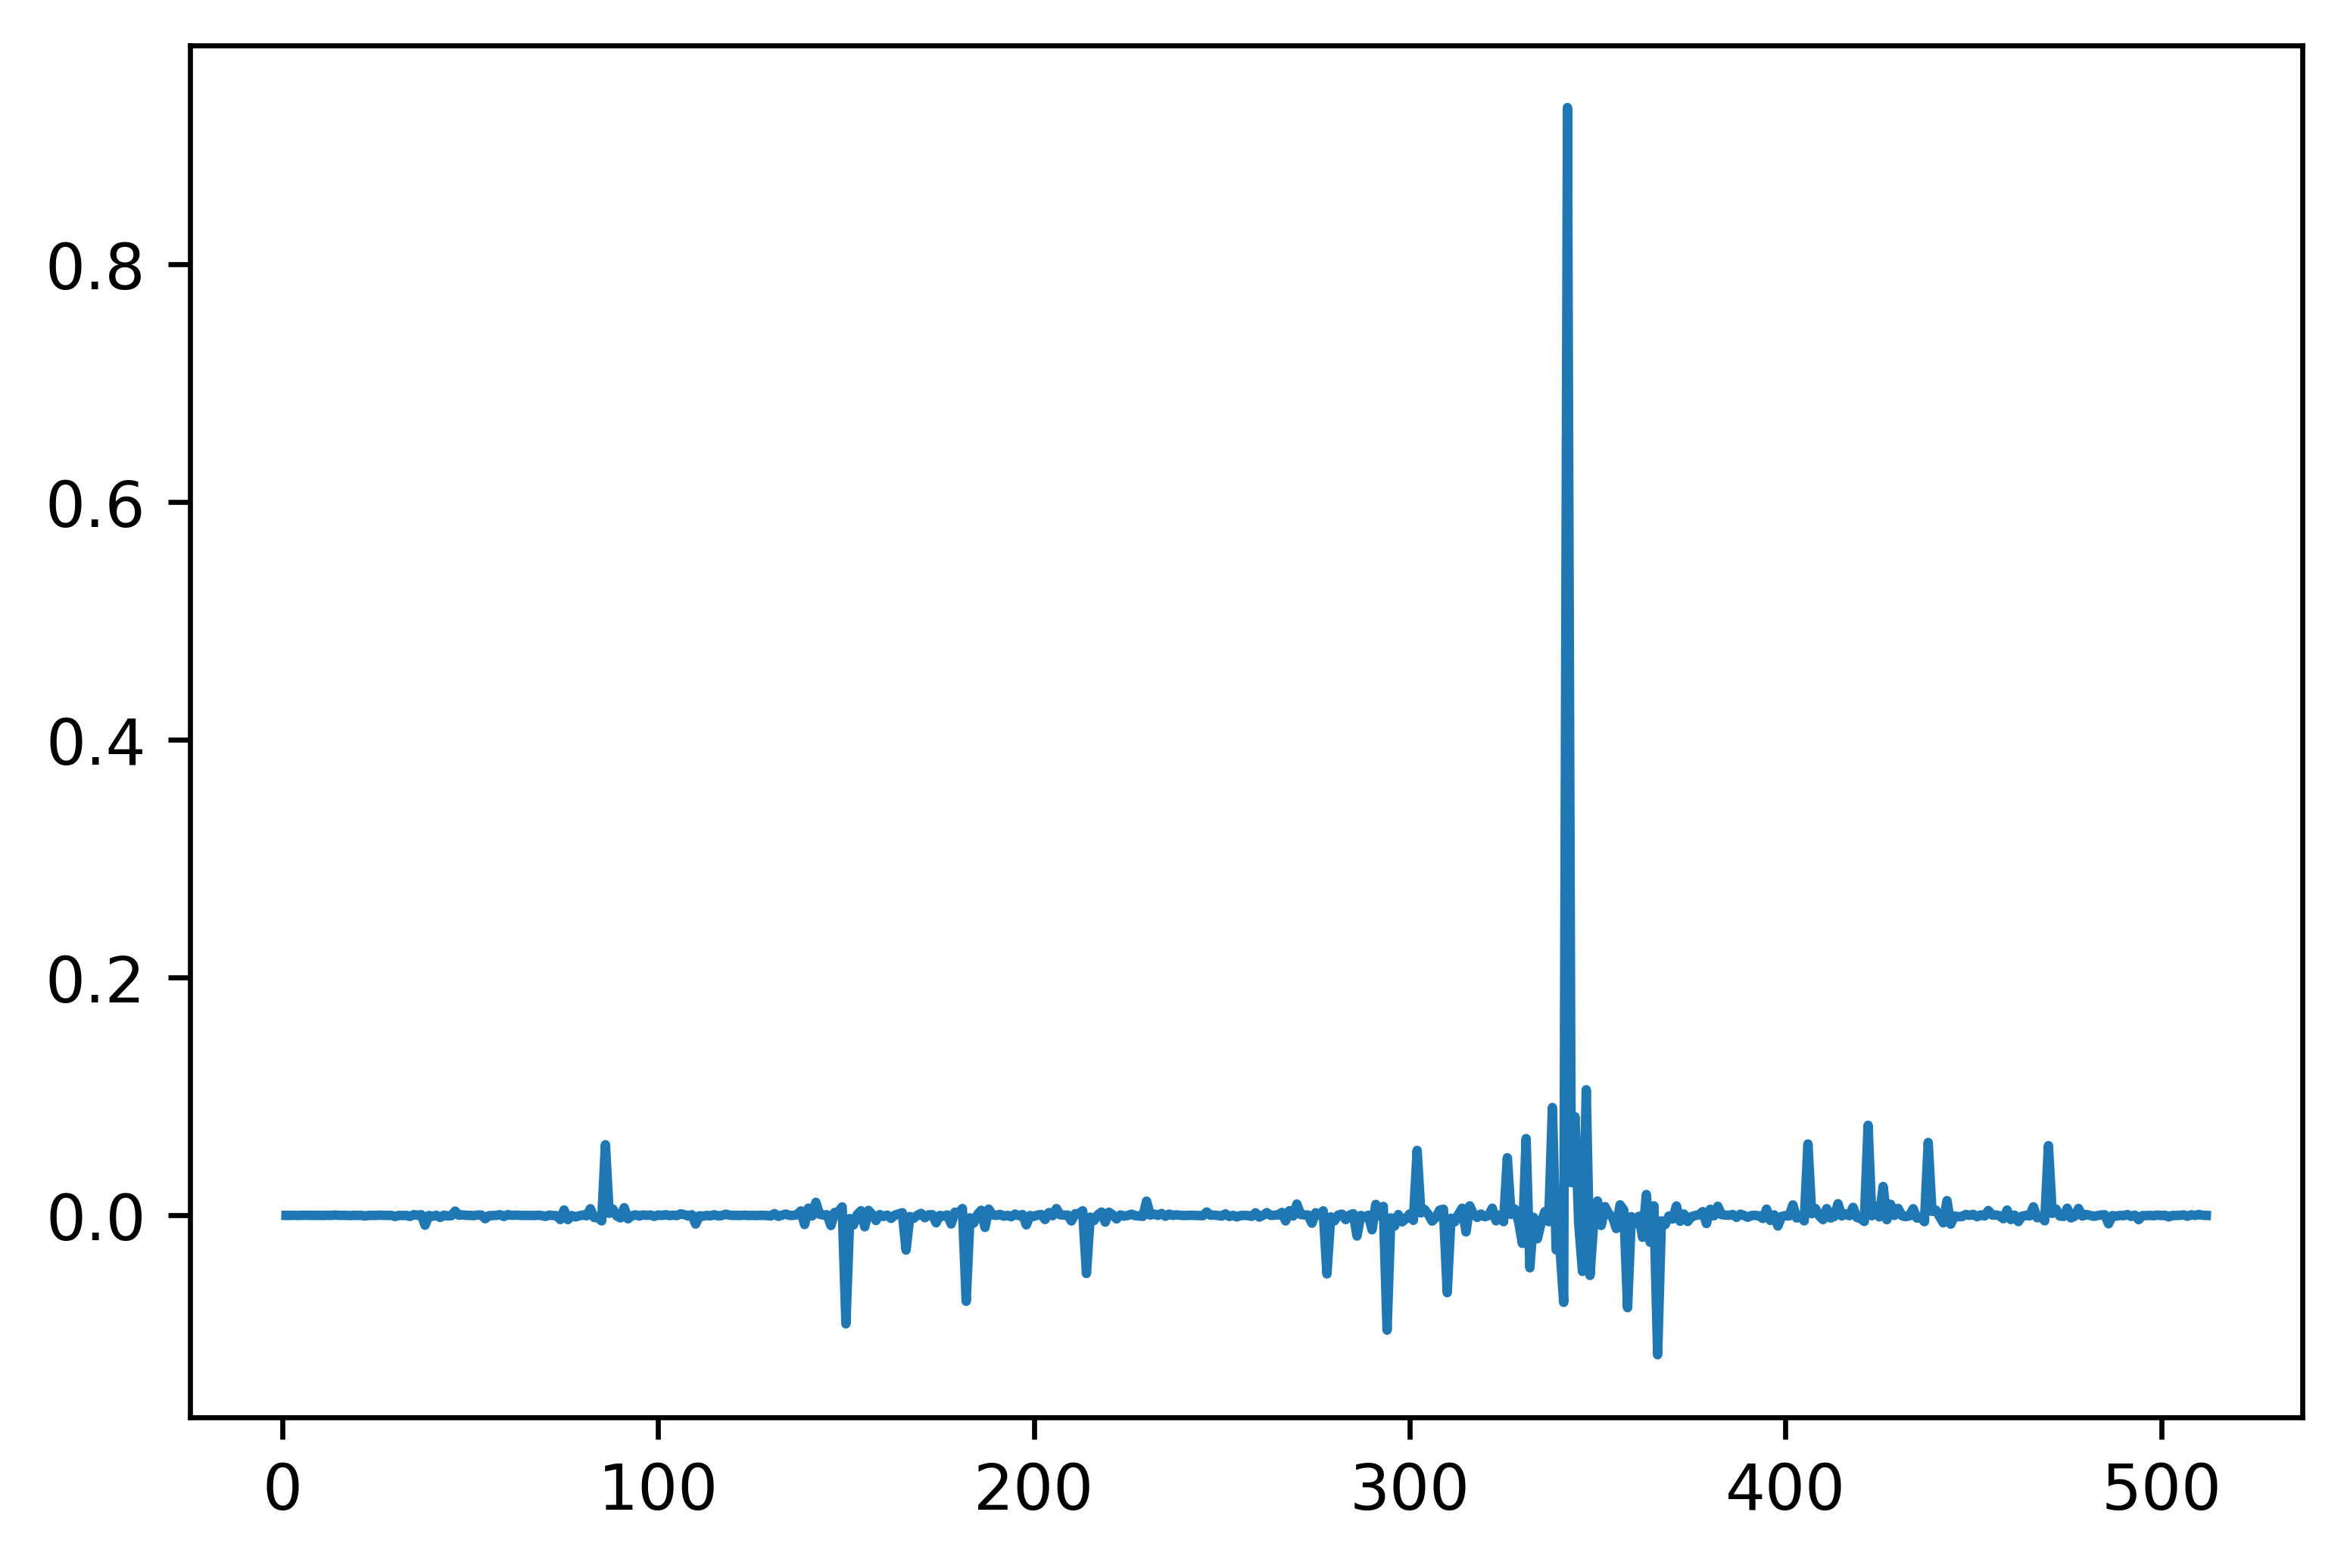

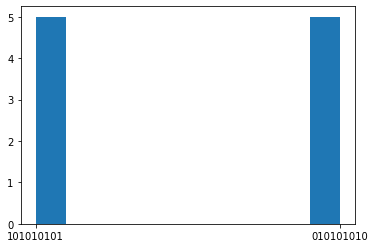

In [23]:
# running multiple trials:
# construct VQE
spsa = SPSA(maxiter=300)
ry = TwoLocal(qubitOp.num_qubits, "ry", "cz", reps=5, entanglement="linear")
vqe = VQE(ry, optimizer=spsa, quantum_instance=quantum_instance)

# run vqe multiple times:
m = 10
results = []
high_probs = []
for i in range(m):
    result = vqe.compute_minimum_eigenvalue(qubitOp)
    # counting output with whether more spin up / spin down
    x = max_cut.sample_most_likely(result.eigenstate)
    qubit_string = ""
    for j in x:
        qubit_string += str(int(j))
    high_probs.append(qubit_string)
    print("Trial " + str(i) + ":")
    print("energy:", result.eigenvalue.real)
    print("time:", result.optimizer_time)
    print("max-cut objective:", result.eigenvalue.real + offset)
    print("solution:", x)
    print("solution objective:", qp.objective.evaluate(x))
    print("sum of eigenstates squared: ", sum(np.conj(result.eigenstate) * result.eigenstate))
    # draw the eigenstates.
    plt.figure(dpi = 600)
    horizontal = np.linspace(1, len(result.eigenstate), num = len(result.eigenstate))
    plt.plot(horizontal, result.eigenstate)
    plt.show()
    print()
    results.append(result)

# prob of each result:
plt.figure()
plt.hist(high_probs, density = True)
plt.show()

objective function value: 12.0
variable values: x_0=0.0, x_1=1.0, x_2=0.0, x_3=1.0, x_4=0.0, x_5=1.0, x_6=0.0, x_7=1.0, x_8=0.0
status: SUCCESS


/Users/youfuqian/opt/anaconda3/envs/qiskit_latest/lib/python3.10/site-packages/qiskit_optimization/algorithms/optimization_algorithm.py:138: UserWarning: The sum of probability of samples is not close to 1: f{sum_prob}
  warn("The sum of probability of samples is not close to 1: f{sum_prob}")


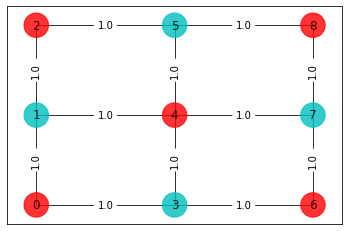

In [24]:
# create minimum eigen optimizer based on VQE
vqe_optimizer = MinimumEigenOptimizer(vqe)

# solve quadratic program
result = vqe_optimizer.solve(qp)
print(result.prettyprint())

colors = ["r" if result.x[i] == 0 else "c" for i in range(n)]
draw_graph(G, colors, pos)